# Water Table Challenge



## Setup and required imports

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))   # Increase font size

import warnings

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

# Data
import pandas as pd
import numpy as np
from operator import itemgetter
import itertools
from collections import defaultdict
from datetime import datetime

# Models, metrics, scalers and functionalities
from sklearn import linear_model
from sklearn import svm

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot
import pydotplus

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

import xgboost

## Introduction

This challenge is part of the Driven Data Competition [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) which uses data from Taarifa and the Tanzanian Ministry of Water. The task is to search for data driven solutions to predict which waterpoints will fail in order to improve maintenance operations and ensure clean potable water availability for the communities across Tanzania. According to Tanzania's Ministry of Water, "development comes only when there is plenty of quality water, which is sustainably utilized".

## Scope of work and expected results
The task is a multi-class classification problem to predict the state of water pumps in Tanzania into three categories: working, need repair, and fail. This report provides an explanation of our analysis of the features, machine learning process, and evaluation of results. 

## Functions

In order to facilitate the evaluation of the impact of the different steps, the following code includes functions for the rendering of relevant metric plots and model training that are extensively used in subsequent steps. They may be called from various modelling scenarios, just by adjusting the subset of data passed as main input arguments.

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix passed in as <cm>.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation = 45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_feature_importance(clf, features, n_features):
    """
    This function plots the importance of the given <features>, as given by the
    classifier <clf> via a horizontal barplot.
    """
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()
    
def train_model(X, y, model, show_figures=True):
    """
    This function returns the given <model> trained with <X> and <y> as
    well as its (cross-validated) accuracy score. By default, the confusion
    matrix and the feature importance barplot are displayed. Set <show_figures>
    to False to change this.
    """
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    model.fit(X, y)
    if show_figures:
        plot_confusion_matrix(conf_mat, np.array(sorted(y.unique())))
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

## Data Reading and Preparation

The dataset is provided in two separate files, one for the training and another one for the test set.

**NOTE: The path specified in the cells below assumes that the csv files are located in the same directory as the notebook.**

In [ ]:
my_path = "./"

In [ ]:
X_train = pd.read_csv(my_path + "X_train.csv", delimiter = ",")
X_train.shape

(59400, 40)

In [ ]:
id_y_train = pd.read_csv(my_path + "id_y_train.csv", delimiter = ",")
id_y_train.shape

(59400, 2)

In [ ]:
X_test = pd.read_csv(my_path + "X_test.csv", delimiter = ",")
X_test.shape

(14850, 40)

Bind *X_train* and *id_y_train* by the column **id**:

In [ ]:
trainset = pd.merge(X_train, id_y_train, on = "id", how = "inner")
trainset.shape

(59400, 41)

Bind *X_test* and a fictitious label column with category level "test":

In [ ]:
y_test = pd.Series(["test"] * len(X_test), name = "status_group")
testset = pd.concat([X_test, y_test], axis = 1)
testset.shape

(14850, 41)

Concatenate the training and test sets:

In [ ]:
Xy = trainset.append(testset)

In [ ]:
Xy.shape

(74250, 41)

In [ ]:
Xy.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

Subdivide the feature columns into numeric and non-numeric for initial exploration purposes:

In [ ]:
object_cols = Xy.columns[Xy.dtypes == 'object'].tolist()[:-1]

In [ ]:
numeric_cols = Xy.columns[Xy.dtypes != 'object'].tolist()

## Feature Exploratory Analysis

Explore the distribution of the training labels:

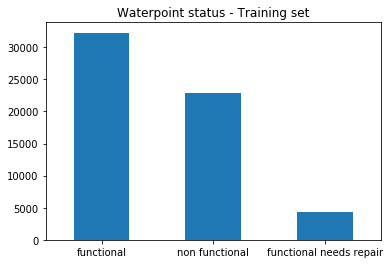

In [ ]:
trainset['status_group'].value_counts().plot(kind = 'bar')

plt.xticks(rotation=0)
plt.title("Waterpoint status - Training set")
plt.show()

### Explore the columns inferred as numeric:

In [ ]:
Xy[numeric_cols].head(3)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009


In [ ]:
Xy.shape

(74250, 41)

Check for null values in numeric columns:

In [ ]:
Xy[numeric_cols].isnull().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

Initially there does not seem to be NAs, but these could be encoded numerically.

In [ ]:
Xy[numeric_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Column **id** comprises unique values throughout, confirming that it can be used as index

In [ ]:
Xy["id"].nunique() == Xy.shape[0]

True

In [ ]:
Xy["amount_tsh"].value_counts()

0.0       52049
500.0      3874
50.0       3103
1000.0     1858
20.0       1812
          ...  
5400.0        1
59.0          1
12.0          1
220.0         1
2550.0        1
Name: amount_tsh, Length: 102, dtype: int64

In [ ]:
Xy["amount_tsh"].value_counts()/len(Xy)*100

0.0       70.099663
500.0      5.217508
50.0       4.179125
1000.0     2.502357
20.0       2.440404
            ...    
5400.0     0.001347
59.0       0.001347
12.0       0.001347
220.0      0.001347
2550.0     0.001347
Name: amount_tsh, Length: 102, dtype: float64

In [ ]:
X_train["amount_tsh"].value_counts()/len(X_train)*100

0.0         70.099327
500.0        5.222222
50.0         4.161616
1000.0       2.505051
20.0         2.462963
              ...    
8500.0       0.001684
6300.0       0.001684
220.0        0.001684
138000.0     0.001684
12.0         0.001684
Name: amount_tsh, Length: 98, dtype: float64

70% of the waterpoints (referred to the total dataset and the training set as well, as this feature has been conveniently stratified) have a zero total static head, which makes a pump useless -> not an issue if the waterpoint works by gravity.
NOTE: Compare this later with the **extraction_type** column!

Still, feature **amount_tsh** seems somewhat unreliable (values like 85000.0 or 138000.0 make no physical sense)!

Consider if **gps_height** should be left as is or binned (below0, above0). Attention to the 0 values must be paid, as they most likely represent nulls.

In [ ]:
Xy["gps_height"].value_counts()/len(Xy)*100                 # 34% of waterpoints are at height 0, the rest are very scattered

 0       34.544108
-16       0.095623
-15       0.092929
-13       0.091582
-19       0.087542
           ...    
 2457     0.001347
 2091     0.001347
 2536     0.001347
 2408     0.001347
 2015     0.001347
Name: gps_height, Length: 2456, dtype: float64

In [ ]:
Xy[Xy["gps_height"] > 0]["gps_height"].count()/len(Xy)*100  # 63% of waterpoints above sea level
Xy[Xy["gps_height"] < 0]["gps_height"].count()/len(Xy)*100  # 2.5% of waterpoints below sea level

2.533333333333333

**latitude** values make sense (between just below the equator down to 12&deg;S)

**longitude** values have inconsistencies (0&deg;E is not possible for Tanzania)

In [ ]:
Xy["longitude"].value_counts()/len(Xy)*100                 # 3% of longitude values are wrong (0 is the same as missing)
Xy[Xy["longitude"] > 0]["longitude"].sort_values()         # Otherwise the minimum longitude is 29.6E, which is correct

35351    29.607122
38853    29.607201
40328    29.610321
24082    29.610965
53947    29.611947
           ...    
7672     40.325016
42877    40.325226
32602    40.325240
54030    40.344301
735      40.345193
Name: longitude, Length: 71981, dtype: float64

**num_private** column has no description and is not intuitive to infer:

In [ ]:
Xy["num_private"].value_counts()/len(Xy)*100

0      98.719192
1       0.126599
6       0.123906
5       0.080808
8       0.078114
         ...    
30      0.001347
669     0.001347
668     0.001347
213     0.001347
62      0.001347
Name: num_private, Length: 68, dtype: float64

In [ ]:
X_train["num_private"].value_counts()/len(X_train)*100

0      98.725589
6       0.136364
1       0.122896
5       0.077441
8       0.077441
         ...    
180     0.001684
213     0.001684
23      0.001684
55      0.001684
94      0.001684
Name: num_private, Length: 65, dtype: float64

Almost 99% of this column is uninformative! Consider dropping it or binarising it into 0 (majority class) and not0 (minority, almost anomaly)

**region_code** seems consistent, but it may be a proxy for categorical column **region** (check with catogorical columns)

In [ ]:
Xy["region_code"].nunique()                             # 27 distinct region codes
X_train["region_code"].nunique()                        # all 27 region codes present in training set
Xy["region_code"].value_counts()/len(Xy)*100

11    8.899663
17    8.530640
12    7.756229
3     7.399327
5     6.840404
18    5.633670
19    5.150168
2     4.995286
16    4.758249
10    4.452525
4     4.235690
1     3.742761
13    3.415488
14    3.350842
20    3.301010
15    3.019529
6     2.736700
21    2.655892
80    2.068687
60    1.748148
90    1.525926
7     1.373737
99    0.689562
9     0.672054
24    0.541414
8     0.505051
40    0.001347
Name: region_code, dtype: float64

In [ ]:
Xy["district_code"].nunique()                         # 20 distinct district codes
X_train["district_code"].nunique()                    # all 20 district codes present in training set
Xy["district_code"].value_counts()/len(Xy)*100

1     20.604714
2     18.759596
3     16.863300
4     15.155556
5      7.310438
6      6.879461
7      5.610774
8      1.726599
30     1.691582
33     1.431650
53     1.240404
43     0.879461
13     0.668013
23     0.484848
63     0.355556
62     0.171044
60     0.102357
0      0.036364
80     0.017508
67     0.010774
Name: district_code, dtype: float64

Do districts embed regions? If so, there shouldn't be regions belonging to more than one district. Check:

In [ ]:
Xy.groupby(by = ["district_code"])[["region_code"]].nunique()

,region_code
district_code,
0,1
1,20
2,18
3,20
4,17
5,13
6,12
7,8
8,4


Districts and regions are not hierarchically defined, there are many overlappings, hence one of these features is probably redundant.

In the **population** column, 36% of rows have value 0. These could be mistakes or numeric encoding for NA (maybe waterpoints where population ultimately migrated?).

Do we impute these entries? The distribution is considerably skewed.

In [ ]:
print(Xy['population'].skew())

11.7806153769686


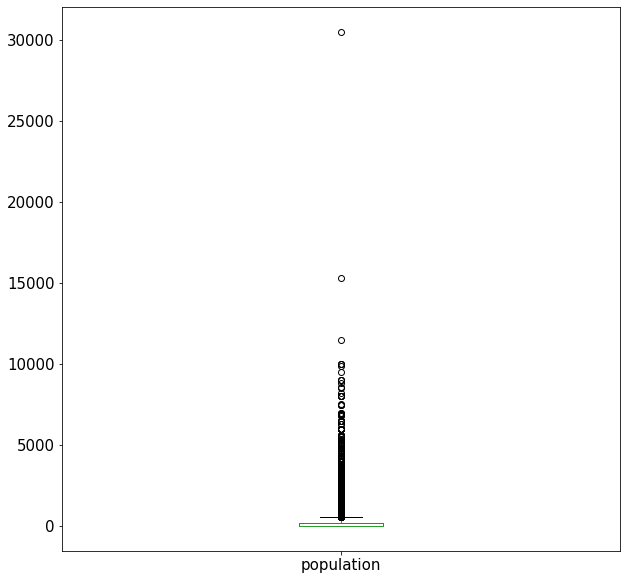

In [ ]:
plt.figure(figsize=(10,10))
X_train.boxplot(['population'], grid=False, fontsize=15)
plt.show()

In [ ]:
Xy["population"].value_counts()/len(Xy)*100

0       36.140067
1       11.827609
200      3.191919
150      3.135354
250      2.810774
          ...    
1193     0.001347
593      0.001347
1065     0.001347
785      0.001347
895      0.001347
Name: population, Length: 1128, dtype: float64

In [ ]:
Xy["population"].describe()

count    74250.000000
mean       180.750828
std        471.086120
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [ ]:
statistics.median(X_train["population"])

25.0

 Most values are close to zero as showed in the Box Plot, imputation is prefered to be with the median considering the significant skewness.

In **construction_year**, 35% of the entries have a 0 value, could be an NA encoding. Consider imputing these.

Inspect the skewness of this feature's distribution:

In [ ]:
print(Xy['construction_year'].skew())

-0.6297840687840902


In [ ]:
X_train[(X_train["construction_year"] != 0)]['construction_year'].describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

In [ ]:
Xy["construction_year"].value_counts()/len(Xy)*100

0       34.975084
2010     4.463300
2008     4.367677
2009     4.304377
2000     3.472054
2007     2.639731
2006     2.548148
2011     2.142761
2003     2.126599
2004     1.908418
2012     1.814141
2002     1.808754
1995     1.727946
2005     1.717172
1978     1.706397
1999     1.645791
1998     1.602694
1985     1.585185
1990     1.583838
1996     1.373737
1980     1.353535
1984     1.306397
1994     1.265993
1982     1.247138
1972     1.201347
1997     1.105724
1974     1.096296
1992     1.086869
1993     1.003367
2001     0.915825
1988     0.884848
1983     0.800000
1975     0.755556
1986     0.744781
1976     0.707071
1970     0.663973
1991     0.548148
1989     0.533333
1987     0.498316
1981     0.391919
1977     0.332660
1979     0.329966
1973     0.305724
2013     0.281481
1971     0.238384
1960     0.167003
1963     0.144108
1967     0.142761
1968     0.125253
1969     0.103704
1964     0.064646
1962     0.048485
1961     0.037710
1965     0.028283
1966     0.025589
Name: cons

Imputation is preferred to be with the mean of non-zero years, as it is considered that a majority a missing values stem from older decades. It may be convenient to infer another feature (**construction_age**) measuring the age of the installation.

#### Explore the columns inferred as non-numeric:

Initially all these columns are inferred as type *object*

In [ ]:
Xy[object_cols].head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,Mara,Serengeti,Natta,NaN,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,Manyara,Simanjiro,Ngorika,True,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,True,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Initial inspection of missing values:

In [ ]:
Xy[object_cols].isnull().sum()

date_recorded                0
funder                    4504
installer                 4532
wpt_name                     0
basin                        0
subvillage                 470
region                       0
lga                          0
ward                         0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

It may be useful to transform **date_recorded** into a time delta. 

Also, splitting into year, month and day could be convenient:
* check if **year** may be useful to infer **construction_year**
* **month** as separate feature

In [ ]:
Xy["date_recorded"] = pd.to_datetime(Xy["date_recorded"])

In [ ]:
Xy["year_recorded"] = Xy["date_recorded"].dt.year
Xy["month_recorded"] = Xy["date_recorded"].dt.month

In [ ]:
Xy["year_recorded"].value_counts()

2011    35908
2013    30210
2012     8089
2004       41
2002        1
2001        1
Name: year_recorded, dtype: int64

**year_recorded** is a useful feature, though it cannot be used to infer **construction_year**.

Categorical feature **season** inferred from **month_recorded**:

In [ ]:
Xy["season"] = Xy["month_recorded"].replace({1:"short dry",
                                             2:"short dry",
                                             3:"rainy",
                                             4:"rainy",
                                             5:"rainy",
                                             6:"dry",
                                             7:"dry",
                                             8:"dry",
                                             9:"dry",
                                             10:"dry",
                                             11:"short rainy",
                                             12:"short rainy"})

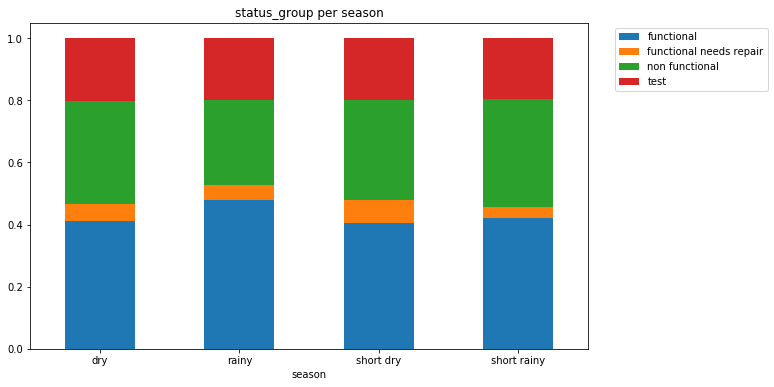

In [ ]:
Xy.groupby(["season"])["status_group"]\
  .value_counts(normalize=True)\
  .unstack(level=1)\
  .plot.bar(stacked=True,figsize=(10,6))

plt.xticks(rotation=0)
plt.title("status_group per season")
plt.legend(bbox_to_anchor=(1.04,1))
plt.show()

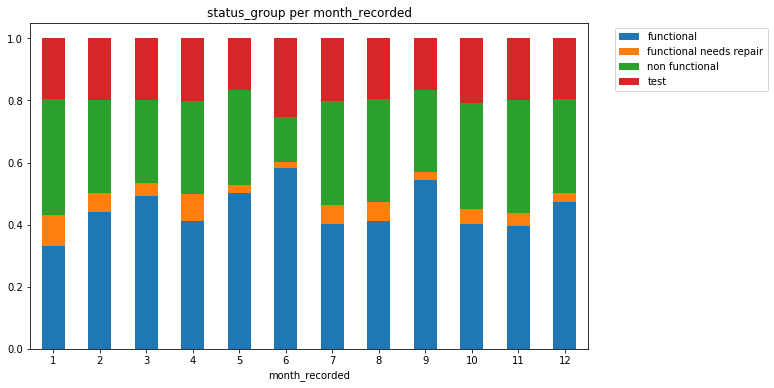

In [ ]:
Xy.groupby(["month_recorded"])["status_group"]\
  .value_counts(normalize=True)\
  .unstack(level=1)\
  .plot.bar(stacked=True,figsize=(10,6))

plt.xticks(rotation=0)
plt.title("status_group per month_recorded")
plt.legend(bbox_to_anchor=(1.04,1))
plt.show()

**date_recorded** refers to the specific date where the water pump was inspected and the measures where taken. Weather conditions and seasonality could influence these measurements. That is why new season parameters are included, taking into consideration that Tanzania seasons are divided into:

* January-February: Short Dry period
* March-May: Rainy period
* June-October: Dry Period
* November-December: Short rainy period

Column **funder** has null (NaN) values

In [ ]:
Xy["funder"].value_counts(dropna = False)/len(Xy)*100

Government Of Tanzania    15.217508
NaN                        6.065993
Danida                     5.261953
Hesawa                     3.746801
Rwssp                      2.293603
                            ...    
Fpct Mulala                0.001347
Steven Nyangarika          0.001347
Colony                     0.001347
Tz As                      0.001347
Mhoranzi                   0.001347
Name: funder, Length: 2141, dtype: float64

Check the count of unique funders (excludes the null entry by default)

In [ ]:
Xy["funder"].nunique()

2140

Percentage of null **funder** values wrt the training dataset X_tr:

In [ ]:
len(X_train[X_train["funder"].isnull()]["funder"])/len(X_train)*100

6.11952861952862

Given the scatter of funders with only one entry, and that with 2411 different funders it seems complicated to find  a common cluster parameter for the specific feature, it is decided to drop **funder**.

Check the **installer** column:

In [ ]:
Xy["installer"].value_counts(dropna = False)/len(Xy)*100

DWE                            29.294276
NaN                             6.103704
Government                      3.073401
RWE                             2.017508
Commu                           1.814141
                                 ...    
GDP                             0.001347
Institutional                   0.001347
Kalitesi                        0.001347
Sagaswe                         0.001347
Rural Drinkung Water Supply     0.001347
Name: installer, Length: 2411, dtype: float64

Same reasoning as with **funder** applies here, hence this feature is dropped as well.

**wpt_name** should play the role of a label but it has null values ("none") and it is not unique (also, the numeric column **id** is already a valid index). Hence, **wpt_name** is dropped.

In [ ]:
Xy["wpt_name"].value_counts()/len(Xy)*100

none                5.979798
Shuleni             2.940067
Zahanati            1.392593
Msikitini           0.871380
Kanisani            0.525253
                      ...   
Kwasonzogo          0.001347
Kwa Joyce Msengi    0.001347
Kwa Mzee Stephan    0.001347
Kwa Loshili         0.001347
Kwa Apolinali       0.001347
Name: wpt_name, Length: 45684, dtype: float64

In [ ]:
Xy["basin"].value_counts()/len(Xy)*100

Lake Victoria              17.334680
Pangani                    15.007407
Rufiji                     13.450505
Internal                   12.985859
Lake Tanganyika            10.844444
Wami / Ruvu                10.204714
Lake Nyasa                  8.527946
Ruvuma / Southern Coast     7.524579
Lake Rukwa                  4.119865
Name: basin, dtype: float64

In [ ]:
X_train["basin"].value_counts()/len(X_train)*100

Lake Victoria              17.252525
Pangani                    15.050505
Rufiji                     13.427609
Internal                   13.106061
Lake Tanganyika            10.828283
Wami / Ruvu                10.079125
Lake Nyasa                  8.560606
Ruvuma / Southern Coast     7.563973
Lake Rukwa                  4.131313
Name: basin, dtype: float64

**basin** is a nice *clustering* feature (hydrographic clustering) and has no null values.

In [ ]:
Xy["subvillage"].value_counts(dropna = False)/len(Xy)*100

Shuleni       0.870034
Majengo       0.849832
Madukani      0.847138
NaN           0.632997
Kati          0.628956
                ...   
Ndinga        0.001347
Mwang'Onya    0.001347
Mwakija       0.001347
Manangase     0.001347
Butwa         0.001347
Name: subvillage, Length: 21426, dtype: float64

Percentage of null **subvillage** values wrt the training dataset X_train:

In [ ]:
len(X_train[X_train["subvillage"].isnull()]["subvillage"])/len(X_train)*100

0.6245791245791246

Given the great scatter (not one subvillage accounts for 1% or more of the examples) this feature is not informative, and therefore dropped.

In [ ]:
Xy["region"].value_counts()/len(Xy)*100

Iringa           8.887542
Shinyanga        8.475421
Mbeya            7.754882
Kilimanjaro      7.399327
Morogoro         6.785185
Kagera           5.621549
Arusha           5.536700
Mwanza           5.248485
Kigoma           4.758249
Pwani            4.486195
Ruvuma           4.452525
Tanga            4.290909
Dodoma           3.742761
Singida          3.415488
Tabora           3.321212
Mara             3.301010
Rukwa            3.019529
Mtwara           2.887542
Manyara          2.655892
Lindi            2.585859
Dar es Salaam    1.373737
Name: region, dtype: float64

There are 21 distinct values, whereas **region_code** had 27. Either of them could work as *geographic* clustering feature. Check if **region** fits hierarchically with **district_code**:

In [ ]:
Xy.groupby(by = ["district_code"])[["region"]].nunique()

,region
district_code,
0,1
1,21
2,19
3,20
4,18
5,13
6,12
7,8
8,4


**region** is not hierarchically embedded in **district_code**, and it does not provide more information than **region_code**.

It is decided to drop **region_code** in favour of **region**.

In [ ]:
Xy["lga"].value_counts()/len(Xy)*100

Njombe          4.212795
Moshi Rural     2.109091
Arusha Rural    2.048485
Bariadi         2.000000
Rungwe          1.859933
                  ...   
Moshi Urban     0.138721
Kigoma Urban    0.127946
Arusha Urban    0.110438
Lindi Urban     0.032323
Nyamagana       0.002694
Name: lga, Length: 125, dtype: float64

In [ ]:
Xy["ward"].value_counts()/len(Xy)*100

Igosi              0.519865
Imalinyi           0.428283
Siha Kati          0.400000
Mdandu             0.393266
Nduruma            0.351515
                     ...   
Kinungu            0.001347
Matarawe           0.001347
Mwalugulu          0.001347
Izia               0.001347
Uwanja wa Ndege    0.001347
Name: ward, Length: 2098, dtype: float64

**ward** seems too scattered to be informative (not one value accounts for even 0.6%) and is therefore dropped.

**lga** could be an administrative/political *clustering* feature, but it has too many levels and classification is not intuitive. Therefore, this feature is dropped.

In [ ]:
Xy["public_meeting"].value_counts(dropna = False)/len(Xy)*100

True     85.857239
False     8.546801
NaN       5.595960
Name: public_meeting, dtype: float64

In [ ]:
X_train["public_meeting"].value_counts(dropna = False)/len(X_train)*100

True     85.877104
False     8.510101
NaN       5.612795
Name: public_meeting, dtype: float64

**public_meeting** is a highly unbalanced binary feature, with 5.6% missing values.

As it is hard to assume whether or not public meetings were actually held, we consider binning this variable into:

* True
* False 
* Unknown 


In [ ]:
Xy["recorded_by"].value_counts()/len(Xy)*100

GeoData Consultants Ltd    100.0
Name: recorded_by, dtype: float64

**recorded_by** comprises only one value, constant across the whole dataset. This feature is uninformative and must be dropped.

Note that **scheme_management** has null values in the form of NaN (6.5%) and None (0.0013%, although None is not present in the test set!)

One category alone accounts for 62% of the rows, the first 5 categories (excluding NaN) account for 85% of the rows. Although it could be feasible to binarise the feature into *VWC* and *not VWC*, it is decided to drop the feature altogether.

In [ ]:
Xy["scheme_management"].value_counts(dropna = False)/len(Xy)*100

VWC                 61.841077
WUG                  8.748822
NaN                  6.526599
Water authority      5.353535
WUA                  4.782492
Water Board          4.662626
Parastatal           2.860606
Company              1.806061
Private operator     1.785859
Other                1.341414
SWC                  0.165657
Trust                0.123906
None                 0.001347
Name: scheme_management, dtype: float64

In [ ]:
X_test["scheme_management"].value_counts(dropna = False)/len(X_test)*100

VWC                 61.441077
WUG                  8.686869
NaN                  6.525253
Water authority      5.535354
Water Board          4.808081
WUA                  4.498316
Parastatal           2.989899
Company              1.885522
Private operator     1.771044
Other                1.548822
SWC                  0.175084
Trust                0.134680
Name: scheme_management, dtype: float64

**scheme_name** has about half the entries as NaN, and the rest are greatly scattered. Feature **scheme_name** is consequently dropped as well.

In [ ]:
Xy["scheme_name"].value_counts(dropna = False)/len(Xy)*100

NaN                            47.485522
K                               1.155556
None                            1.069360
Borehole                        0.948148
Chalinze wate                   0.674747
                                 ...    
Nanganga                        0.001347
World Bank Water Project        0.001347
FiWater                         0.001347
Kani                            0.001347
lgongolo gravity water sche     0.001347
Name: scheme_name, Length: 2869, dtype: float64

In [ ]:
Xy["permit"].value_counts(dropna = False)/len(Xy)*100

True     65.462626
False    29.428956
NaN       5.108418
Name: permit, dtype: float64

In [ ]:
X_train["permit"].value_counts(dropna = False)/len(X_train)*100

True     65.407407
False    29.447811
NaN       5.144781
Name: permit, dtype: float64

**permit** is an intuitive binary feature. About 5% of the values are missing (NaN). It is reasonable to assume that absence of a permit record implies the absence of the permit itself, and hence the NaN values could be imputed as *False*.

In [ ]:
Xy["extraction_type"].value_counts()/len(Xy)*100

gravity                      44.798653
nira/tanira                  13.744108
other                        10.911785
submersible                   8.056566
swn 80                        6.179125
mono                          4.886195
india mark ii                 4.079461
afridev                       2.973737
ksb                           2.410774
other - rope pump             0.770370
other - swn 81                0.382492
windmill                      0.204714
india mark iii                0.181818
cemo                          0.145455
other - play pump             0.136027
walimi                        0.080808
climax                        0.055219
other - mkulima/shinyanga     0.002694
Name: extraction_type, dtype: float64

**extraction_type** has *other* (10%) as a category, though it is unclear if it is representing nulls. *gravity* is the predominant (45%) category, and most of the remaining categories represent pump types.

In [ ]:
Xy["extraction_type_group"].value_counts()/len(Xy)*100

gravity            44.798653
nira/tanira        13.744108
other              10.911785
submersible        10.467340
swn 80              6.179125
mono                4.886195
india mark ii       4.079461
afridev             2.973737
rope pump           0.770370
other handpump      0.602020
wind-powered        0.204714
other motorpump     0.200673
india mark iii      0.181818
Name: extraction_type_group, dtype: float64

**extraction_type_group** is a slight simplification of **extraction_type**, and does not provide additional information.

In [ ]:
Xy["extraction_type_class"].value_counts()/len(Xy)*100

gravity         44.798653
handpump        27.760269
other           10.911785
submersible     10.467340
motorpump        5.086869
rope pump        0.770370
wind-powered     0.204714
Name: extraction_type_class, dtype: float64

**extraction_type_class** is an even further simplification of **extraction_type**. Since it is the simplest feature of the three, this is the one selected for use, and the handling of category level *other* will take place after dummification. 

In [ ]:
Xy["management"].value_counts()/len(Xy)*100

vwc                 68.180471
wug                 10.919865
water board          4.967003
wua                  4.199327
private operator     3.372391
parastatal           3.002020
water authority      1.512458
other                1.458586
company              1.156902
unknown              0.919865
other - school       0.169697
trust                0.141414
Name: management, dtype: float64

In [ ]:
Xy["management_group"].value_counts()/len(Xy)*100

user-group    88.266667
commercial     6.183165
parastatal     3.002020
other          1.628283
unknown        0.919865
Name: management_group, dtype: float64

**management_group** is chosen over **management**. It has nulls (0.91%) as *unknown* that are handled after dummification.

In [ ]:
Xy["payment"].value_counts()/len(Xy)*100

never pay                42.709764
pay per bucket           15.173064
pay monthly              14.002694
unknown                  13.668687
pay when scheme fails     6.521212
pay annually              6.154882
other                     1.769697
Name: payment, dtype: float64

In [ ]:
Xy["payment_type"].value_counts()/len(Xy)*100

never pay     42.709764
per bucket    15.173064
monthly       14.002694
unknown       13.668687
on failure     6.521212
annually       6.154882
other          1.769697
Name: payment_type, dtype: float64

**payment** and **payment_type** contain the same information, hence **payment_type** is dropped. There are nulls (13.7%) in the form of *unknown*, handled after dummification.

In [ ]:
Xy["water_quality"].value_counts()/len(Xy)*100

soft                  85.528620
salty                  8.191246
unknown                3.158249
milky                  1.353535
coloured               0.839057
salty abandoned        0.569697
fluoride               0.328620
fluoride abandoned     0.030976
Name: water_quality, dtype: float64

In [ ]:
Xy["quality_group"].value_counts()/len(Xy)*100

good        85.528620
salty        8.760943
unknown      3.158249
milky        1.353535
colored      0.839057
fluoride     0.359596
Name: quality_group, dtype: float64

**quality_group** is a simplified version of **water_quality**. Hence, **quality_group** is selected, with the handling of the null values (3.15%, in the form of *unknown*) after dummification.

In [ ]:
Xy["quantity"].value_counts()/len(Xy)*100

enough          55.921886
insufficient    25.449158
dry             10.480808
seasonal         6.835017
unknown          1.313131
Name: quantity, dtype: float64

In [ ]:
Xy["quantity_group"].value_counts()/len(Xy)*100

enough          55.921886
insufficient    25.449158
dry             10.480808
seasonal         6.835017
unknown          1.313131
Name: quantity_group, dtype: float64

**quantity_group** and **quantity** contain the same information, drop **quantity_group**. The null values (1.3%) in the form of *unknown* are handled after dummmification.

In [ ]:
Xy["source"].value_counts()/len(Xy)*100

spring                  28.573737
shallow well            28.471380
machine dbh             18.615488
river                   16.113131
rainwater harvesting     3.855892
hand dtw                 1.492256
lake                     1.279461
dam                      1.131313
other                    0.351515
unknown                  0.115825
Name: source, dtype: float64

In [ ]:
Xy["source_type"].value_counts()/len(Xy)*100

spring                  28.573737
shallow well            28.471380
borehole                20.107744
river/lake              17.392593
rainwater harvesting     3.855892
dam                      1.131313
other                    0.467340
Name: source_type, dtype: float64

In [ ]:
Xy["source_class"].value_counts()/len(Xy)*100

groundwater    77.152862
surface        22.379798
unknown         0.467340
Name: source_class, dtype: float64

**source_type** and **source_class** are both kept, with the handling of nulls after dummification.

In [ ]:
Xy["waterpoint_type"].value_counts()/len(Xy)*100

communal standpipe             47.983838
hand pump                      29.473401
other                          10.787879
communal standpipe multiple    10.250505
improved spring                 1.291582
cattle trough                   0.202020
dam                             0.010774
Name: waterpoint_type, dtype: float64

In [ ]:
Xy["waterpoint_type_group"].value_counts()/len(Xy)*100

communal standpipe    58.234343
hand pump             29.473401
other                 10.787879
improved spring        1.291582
cattle trough          0.202020
dam                    0.010774
Name: waterpoint_type_group, dtype: float64

Keep **waterpoint_type** over **waterpoint_type_group** as it distinguishes between single and multiple standpipes. 

### Summary of Feature Exploration

*Numeric* columns:

* **id** can be set as index (comprises unique values)
* **gps_height** is kept, binning in two levels (below0, above0) and **imputing zero values based on averaging by district**.
* **amount_tsh** seems relevant: 70% of its values are 0 but only 45% of the entries in **extraction_type_class** are described as *gravity*. There are non-physical values as well that could perhaps be removed as outliers, and/or this feature can be binarised into (zero, above0).
* **longitude** and **latitude** could be kept, removing the 3% of missing values in **longitude**, or removed altogether since there are other categorical features that capture location in a *clustered* manner (see **basin** and **region_code**). In this case the latter option is chosen.
* **num_private** is uninformative (almost 99% made of zeros) and should be dropped.
* **region_code** and **district_code** are not hierarchic, there are overlappings. Drop these features, as the categorical feature **region** can play the role of a geographic *clustering*.
* **population** does not have null values as such but it comprises 36% of zeros, to be imputed with the median. 
* **construction_year** is intuitively a relevant feature but includes 35% of nulls (encoded as 0). These are imputed with the average. Also, a new feature **construction_age** is inferred.

*Non-numeric* columns:

* **date_recorded** as a whole (and also its components, such as **year_recorded**, **month_recorded**, **day_recorded**) can provide insights about seasonality influence, alongisde the inferred feature **season**.
* **funder** is dropped. About 6% of values are nulls (NaN) and would need handling. It has too many category levels.
* **installer** is dropped. About 6% of values are nulls (NaN) and would need handling. It has too many category levels.
* **wpt_name** is dropped, as **id** already acts as index.
* **basin** must be kept, it acts as a hydrographic *clustering* feature.
* **subvillage** shows great scatter (all levels below 1%) and has 0.6% of nulls. Drop this feature.
* **region** contains formally the same information as **region_code**. Keep this feature as geographic *clustering*.
* **lga** could be kept acting as a political/administrative *clustering* feature, but it has too many category levels. Drop this feature.
* **ward** is uninformative and is not hierarchically ordered with **lga**. Drop this feature.
* **public_meeting** is kept, though it is a highly unbalanced binary feature, with 5.6% missing values. It is decided to keep it as a three-level caterogorical feature.
* **recorded_by** is uninformative as it only comprises one distinct value across the whole dataset. Drop this feature.
* **scheme_management** has null values in the form of NaN (6.5%) and None (0.0013%, only in the training set!). One category alone accounts for 62% of the rows, the first 5 categories (excluding NaN) account for 85% of the rows. Drop this feature.
* **scheme_name** has about half the entries as NaN, and the rest are greatly scattered. Drop this feature.
* **permit** is an intuitive binary feature that must be kept. About 5% of the values are missing (NaN). It is reasonable to assume that absence of a permit record implies the absence of the permit itself, and hence the NaN values are imputed as *False*.
* **extraction_type**, **extraction_type_group** and **extraction_type_class**. **extraction_type_class** is the greatest simplification of **extraction_type**. Since it is the simplest feature of the three, this is the one selected for use, and the handling of category level *other* will take place after dummification. 
* **management** and **management_group**. **management_group** seems simpler and more intuitive, keep this feature and drop the other. There are nulls (0.91%) as category level *unknown* that are handled after dummification.
* **payment** and **payment_type** contain the same information, hence drop **payment_type**. There are nulls (13.7%) in the form of category level *unknown* that are handled after dummification.
* **quality_group** is a simplified version of **water_quality**. Keep **quality_group**, handling the null values (3.15%) in the form of cateogry level *unknown* after dummification.
* **quantity_group** and **quantity** contain the same information, drop **quantity_group** and handle the null values (1.3%) in the form of category level *unknown* after dummification.
* **source**, **source_type** and **source_class**. Keep **source_type** and **source_class** out of the three columns, though it may have null values hidden in the *other* category level, to be handled after dummification.
* **waterpoint_type** and **waterpoint_type_group**. Keep **waterpoint_type** over **waterpoint_type_group** as it distinguishes between single and multiple standpipes.

### Basic Baseline Model

Create an initial dataframe dropping all the uninformative features, as well as the categorical features with a large number of levels:

In [ ]:
initial_numeric_cols = ["id",
                        "gps_height",
                        "amount_tsh",
                        "population",
                        "year_recorded",
                        "construction_year"]

In [ ]:
initial_object_cols = ["basin",
                       "season",
                       "month_recorded",
                       "region",
                       "public_meeting",
                       "permit",
                       "extraction_type_class",
                       "management_group",
                       "payment",
                       "quality_group",
                       "quantity",
                       "source_type",
                       "source_class",
                       "waterpoint_type"]

In [ ]:
Xy_init = Xy[initial_numeric_cols + initial_object_cols + ["status_group"]].copy()

Simply drop **all** rows with missing values:

In [ ]:
Xy_init = Xy_init.dropna()

In [ ]:
cond_management_group = Xy_init["management_group"] != "unknown"
cond_payment = Xy_init["payment"] != "unknown"
cond_quality_group = Xy_init["quality_group"] != "unknown"
cond_quantity = Xy_init["quantity"] != "unknown"

Xy_init = Xy_init[cond_management_group &
                  cond_payment &
                  cond_quality_group &
                  cond_quantity]

In [ ]:
Xy_init.shape

(58586, 21)

In [ ]:
print("By removing all missing values, the whole dataset has {} rows less than originally.".format(len(Xy) - len(Xy_init)))

By removing all missing values, the whole dataset has 15664 rows less than originally.


Cast the *object* columns to *category*:

In [ ]:
Xy_init[initial_object_cols] = Xy_init[initial_object_cols].astype("category")

In [ ]:
Xy_init.dtypes

id                          int64
gps_height                  int64
amount_tsh                float64
population                  int64
year_recorded               int64
construction_year           int64
basin                    category
season                   category
month_recorded           category
region                   category
public_meeting           category
permit                   category
extraction_type_class    category
management_group         category
payment                  category
quality_group            category
quantity                 category
source_type              category
source_class             category
waterpoint_type          category
status_group               object
dtype: object

Set column **id** as index:

In [ ]:
Xy_init = Xy_init.set_index("id")

Now the *raw* basic dataset is conveniently formatted for the purposes of the current study. In order to have a basic baseline to compare the improvements introduced by the subsequent feature engineering process, a basic (non-regularised) logistic regression model is trained with this dataset as is. Since there are numerical and categorical values, the categorical features in the dataset need to be dummified to enable the ML training. Additionally, the numerical values are scaled as well.

In [ ]:
ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

raw_dummified_Xy = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(Xy_init[initial_numeric_cols[1:]])),
                                           columns = initial_numeric_cols[1:]).reset_index(drop = True),                    
                              pd.DataFrame(ohe.fit_transform(Xy_init[initial_object_cols]).toarray(),
                                           columns = ohe.get_feature_names(initial_object_cols)).reset_index(drop = True),
                              Xy_init['status_group'].reset_index(drop = True)], axis = 1)

In [ ]:
raw_dummified_Xy = raw_dummified_Xy.set_index(Xy_init.index)

In [ ]:
raw_dummified_Xy.shape

(58586, 99)

Retrieve the training set and then cast the target labels to categorical (**if done previously it would assume "test" as a further category level**)

In [ ]:
raw_X_train = raw_dummified_Xy[raw_dummified_Xy["status_group"] != "test"].drop(["status_group"], axis = 1)
raw_y_train = raw_dummified_Xy[raw_dummified_Xy["status_group"] != "test"]["status_group"].astype("category")

Accuracy = 0.7242


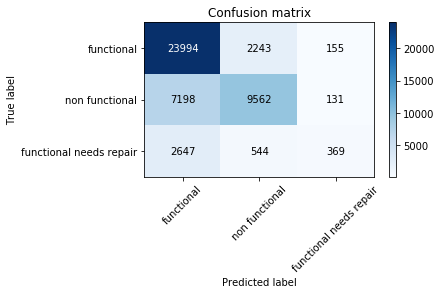

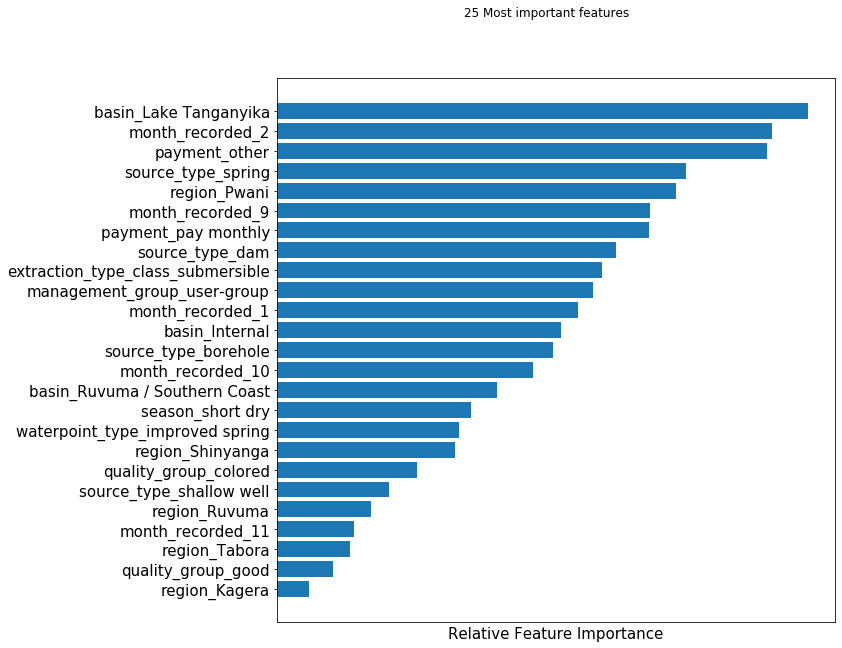

In [ ]:
raw_model, score = train_model(raw_X_train,
                               raw_y_train,
                               linear_model.LogisticRegression(max_iter = 10000, solver = 'lbfgs', penalty = 'none', multi_class = 'auto'))

Check the multi-class confusion matrix by rows:

In [ ]:
Xy_init[Xy_init["status_group"] != "test"]["status_group"].value_counts()

functional                 26392
non functional             16891
functional needs repair     3560
Name: status_group, dtype: int64

To facilitate later model performance comparisons, a table is created comprising the model name, (cross-validated) accuracy score and number of features involved. This table is progressively populated after each model evaluation. 

In [ ]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy', 'Number of features'])
results_df.loc[len(results_df)] = ['Raw LogReg baseline', score, raw_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98


The accuracy for the raw baseline model is around 72%, which is used as a reference value. Later models are evaluated taking this value as benchmark. The features displayed in the feature importance plot can provide initial guidance, though further study of feature relevance is addressed in the next section.

## Feature Cleaning/Selection/Engineering

#### Numeric Columns

Impute the zero values of **gps_height** with the averages by **district_code**, and bin it into two categories: *below_zero* and *above_zero*:

In [ ]:
Xy_clean = Xy.copy()

In [ ]:
Xy_clean = Xy_clean.reset_index(drop = True)

In [ ]:
tmp = Xy.copy()
tmp["gps_height"] = tmp["gps_height"].replace(0, np.nan)

tmp_dict = tmp.groupby(["district_code"]).mean()[["gps_height"]].to_dict()

In [ ]:
tmp_dict["gps_height"][0] = 0
tmp_dict["gps_height"][80] = 0
tmp_dict

{'gps_height': {0: 0,
  1: 999.484088068455,
  2: 1148.0763760350706,
  3: 979.622279285889,
  4: 1261.8956999085087,
  5: 1035.7552508751457,
  6: 770.3651331719128,
  7: 1359.1481814099686,
  8: 1227.448275862069,
  13: 73.15322580645162,
  23: 130.0640668523677,
  30: 1470.8407960199006,
  33: 372.53715898400753,
  43: 170.74193548387098,
  53: 138.40919037199126,
  60: -18.842105263157894,
  62: 24.20967741935484,
  63: 249.8219696969697,
  67: -23.875,
  80: 0}}

In [ ]:
Xy_clean.loc[Xy_clean["gps_height"] == 0,"gps_height"] = Xy_clean[Xy_clean["gps_height"] == 0]["district_code"].map(lambda x:tmp_dict["gps_height"][x])

In [ ]:
Xy_clean["gps_height_bin"] = (Xy_clean["gps_height"] >= 0.0).astype("category")

Bin **amount_tsh** into two categories: *zero* and *not_zero*:

In [ ]:
Xy_clean["amount_tsh_bin"] = (Xy_clean["amount_tsh"] == 0.0).astype("category")

Leave **region** as is:

In [ ]:
Xy_clean["region"] = Xy_clean["region"].astype('category')

**population** has 48% of the entries as 0 or 1, and the distribution of values below shows that 75% of the rows refer to a population up to 250 inhabitants. Most values are close to zero as showed in the Box Plot, imputation is prefered to be with the median rather than the mean, considering the skewness, though the two imputations are attempted. 

In [ ]:
Xy_clean["population"].describe()

count    74250.000000
mean       180.750828
std        471.086120
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [ ]:
population_mean = X_train[(X_train["population"] != 0)]["population"].describe()[1]
population_median = X_train[(X_train["population"] != 0)]["population"].describe()[5]

In [ ]:
Xy_clean["population_impute_mean"] = Xy_clean["population"].replace({0:population_mean}).astype('int')
Xy_clean["population_impute_median"] = Xy_clean["population"].replace({0:population_median}).astype('int')

**construction_year**  It is decided to impute the zero years with the mean. Also, it may be more suitable to derive a numeric feature **construction_age** expressing the time delta since construction instead of the original feature.

In [ ]:
Xy_clean['construction_year'].describe()

count    74250.000000
mean      1298.463650
std        952.349375
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [ ]:
construction_year_mean = X_train[(X_train["construction_year"] != 0)]["construction_year"].describe()[1]

In [ ]:
Xy_clean["construction_year"] = Xy_clean["construction_year"].replace({0:construction_year_mean}).astype('int')

In [ ]:
current = datetime.now()

In [ ]:
Xy_clean["construction_age"] = (current.year - Xy_clean["construction_year"]).astype("int")

In [ ]:
clean_numeric_cols = ["id",
                      "gps_height",
                      "amount_tsh",
                      "population_impute_mean",
                      "population_impute_median",
                      "construction_age"]

Inspect the presence of outliers:

In [ ]:
def remove_outlier(df_in, col_name, thr = 1.5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    
    fence_low  = q1 - thr * iqr
    fence_high = q3 + thr * iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    
    return df_out

Display outliers based solely on the training set:

Analyzing outliers of column: gps_height
15079 outliers removed


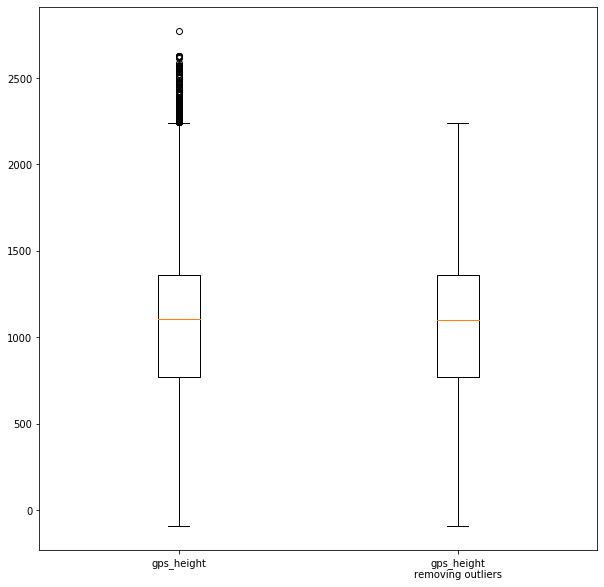

Analyzing outliers of column: amount_tsh
28483 outliers removed


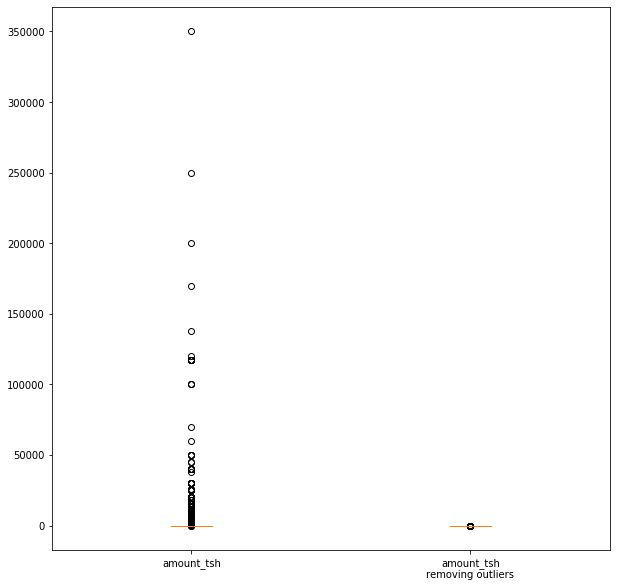

Analyzing outliers of column: population_impute_mean
18992 outliers removed


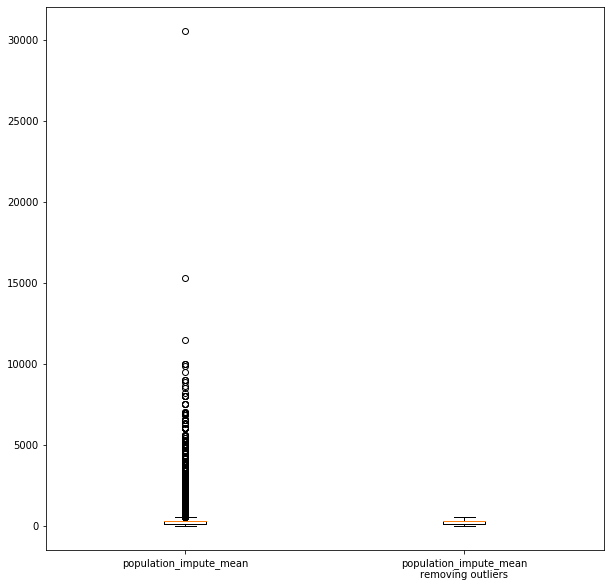

Analyzing outliers of column: population_impute_median
22532 outliers removed


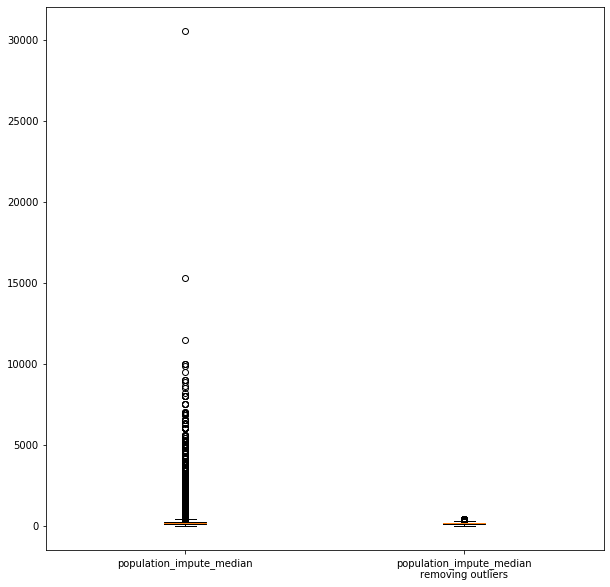

Analyzing outliers of column: construction_age
22854 outliers removed


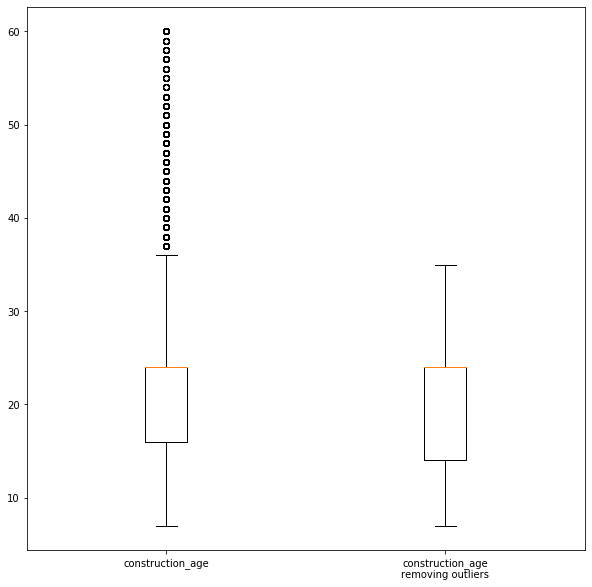

In [ ]:
for columnName in clean_numeric_cols[1:]:
    if Xy_clean[columnName].dtype in ['int64','float64']: 
        print("Analyzing outliers of column: {}".format(columnName))
        len_before = len(Xy_clean)
        
        plt.figure(figsize=(10,10))
        plt.boxplot(Xy_clean[Xy_clean["status_group"] != "test"][columnName], positions = [1])

        dataset2 = remove_outlier(Xy_clean[Xy_clean["status_group"] != "test"], columnName, 1.5) 
        len_after = len(dataset2)
        print("{} outliers removed".format(len_before - len_after))
        
        plt.boxplot(dataset2[columnName], positions = [2])
        plt.xticks([1,2], [columnName, columnName + '\nremoving outliers'])
        plt.show()

As expected, these numeric features have a significant proportion of outliers. Removing them is costly (at least 25% of the training set) and difficult to assess. They are hence left in place, relying on the engineered features to behave better than the original ones.

Inspect the correlations amongst the cleaned numeric features:

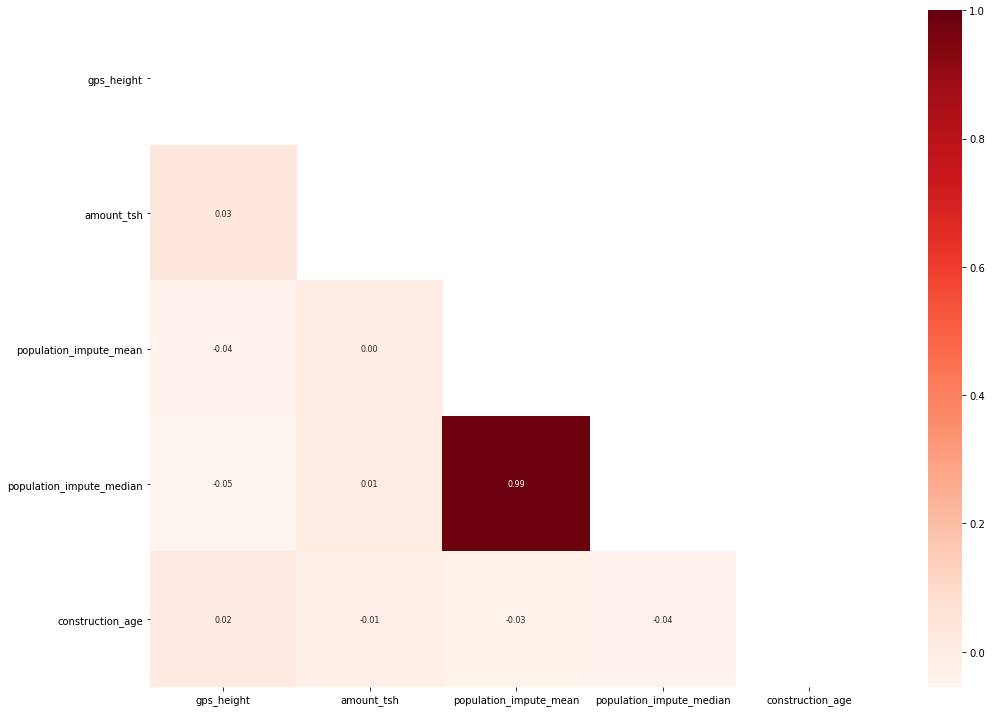

In [ ]:
plt.figure(figsize=(15,10))

matrixmask = np.triu(Xy_clean[clean_numeric_cols[1:]].corr())

cor = Xy_clean[clean_numeric_cols[1:]].corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,
                 fmt='.2f', annot_kws={"size": 8},
                 mask = matrixmask)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Correlation is significant between the two alternatives for population imputing, which is expected. Otherwise the features are effectively uncorrelated.

#### Categorical Columns

In [ ]:
Xy_clean.dtypes

id                                   int64
amount_tsh                         float64
date_recorded               datetime64[ns]
funder                              object
gps_height                         float64
installer                           object
longitude                          float64
latitude                           float64
wpt_name                            object
num_private                          int64
basin                               object
subvillage                          object
region                            category
region_code                          int64
district_code                        int64
lga                                 object
ward                                object
population                           int64
public_meeting                      object
recorded_by                         object
scheme_management                   object
scheme_name                         object
permit                              object
constructio

Disregard **funder** and **installer**, and keep **basin** as is:

**public_meeting** Fill Nas with category Unknown 

In [ ]:
Xy_clean["public_meeting"] = Xy_clean["public_meeting"].astype("category")

In [ ]:
Xy_clean["public_meeting"] = Xy_clean["public_meeting"].cat.add_categories('Unknown').fillna('Unknown')

Keep **permit** imputing NaN values as *False*

In [ ]:
Xy_clean = Xy_clean.replace({"permit": {np.nan: False}})

Xy_clean["permit"] = Xy_clean["permit"].astype("category")

All other object columns remain as is. Group them and cast to category:

In [ ]:
clean_categorical_cols = ['basin',
                          'region',
                          'extraction_type_class',
                          'management_group',
                          'payment',
                          'quality_group',
                          'quantity',
                          'source_type',
                          'source_class',
                          'waterpoint_type',
                          'month_recorded',
                          'season',
                          'amount_tsh_bin',
                          'gps_height_bin',
                          'permit']

In [ ]:
Xy_clean[clean_categorical_cols] = Xy_clean[clean_categorical_cols].astype("category")

In [ ]:
Xy_clean[clean_categorical_cols]

,basin,region,extraction_type_class,management_group,payment,quality_group,quantity,source_type,source_class,waterpoint_type,month_recorded,season,amount_tsh_bin,gps_height_bin,permit
0,Lake Nyasa,Iringa,gravity,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,3,rainy,False,True,False
1,Lake Victoria,Mara,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,3,rainy,True,True,True
2,Pangani,Manyara,gravity,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,2,short dry,False,True,True
3,Ruvuma / Southern Coast,Mtwara,submersible,user-group,never pay,good,dry,borehole,groundwater,communal standpipe multiple,1,short dry,True,True,True
4,Lake Victoria,Kagera,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,7,dry,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,Wami / Ruvu,Pwani,motorpump,user-group,never pay,good,enough,river/lake,surface,communal standpipe,2,short dry,True,True,True
74246,Pangani,Tanga,handpump,user-group,pay annually,salty,insufficient,shallow well,groundwater,hand pump,3,rainy,False,True,False
74247,Internal,Singida,gravity,user-group,never pay,good,insufficient,dam,surface,communal standpipe,3,rainy,True,True,False
74248,Lake Nyasa,Ruvuma,gravity,user-group,never pay,good,insufficient,river/lake,surface,communal standpipe,2,short dry,True,True,True


In [ ]:
Xy_clean[clean_numeric_cols + clean_categorical_cols].dtypes

id                             int64
gps_height                   float64
amount_tsh                   float64
population_impute_mean         int64
population_impute_median       int64
construction_age               int64
basin                       category
region                      category
extraction_type_class       category
management_group            category
payment                     category
quality_group               category
quantity                    category
source_type                 category
source_class                category
waterpoint_type             category
month_recorded              category
season                      category
amount_tsh_bin              category
gps_height_bin              category
permit                      category
dtype: object

Set column **id** as index:

In [ ]:
Xy_clean = Xy_clean.set_index("id")

In [ ]:
ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

dummified_Xy = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(Xy_clean[clean_numeric_cols[1:]])),
                                       columns = clean_numeric_cols[1:]).reset_index(drop = True),                    
                          pd.DataFrame(ohe.fit_transform(Xy_clean[clean_categorical_cols]).toarray(),
                                       columns = ohe.get_feature_names(clean_categorical_cols)).reset_index(drop = True),
                          Xy_clean['status_group'].reset_index(drop = True)], axis = 1)

In [ ]:
dummified_Xy = dummified_Xy.drop(['extraction_type_class_other',
                                  'management_group_unknown',
                                  'management_group_other',
                                  'quality_group_unknown',
                                  'source_class_unknown',
                                  'source_type_other',
                                  'waterpoint_type_other',
                                  'payment_unknown'], axis = 1)

In [ ]:
dummified_Xy = dummified_Xy.set_index(Xy_clean.index)

In [ ]:
dummified_Xy.shape

(74250, 97)

Retrieve the training set and then cast the target labels to categorical (**if done previously it would assume "test" as a further category level**)

Also, start by trying with the numeric feature **population_impute_median**

In [ ]:
basic_X_train = dummified_Xy[dummified_Xy["status_group"] != "test"].drop(["status_group","population_impute_mean"], axis = 1)
basic_y_train = dummified_Xy[dummified_Xy["status_group"] != "test"]["status_group"].astype("category")

Accuracy = 0.7308


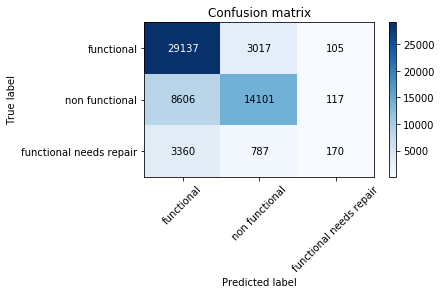

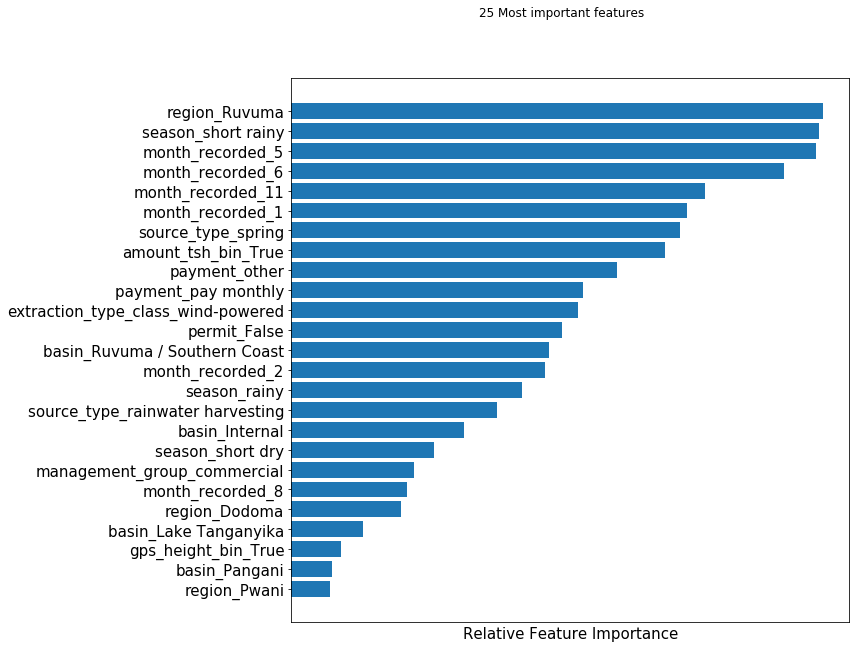

In [ ]:
basic_model, score = train_model(basic_X_train,
                                 basic_y_train,
                                 linear_model.LogisticRegression(max_iter = 10000, solver = 'lbfgs', penalty = 'none', multi_class = 'auto'))

In [ ]:
results_df.loc[len(results_df)] = ['LogReg Baseline FE median', score, basic_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95


Retry but with the numeric feature **population_impute_mean** instead (it should not make a difference since it does not seem to be a relevant feature)

In [ ]:
basic_X_train_avg = dummified_Xy[dummified_Xy["status_group"] != "test"].drop(["status_group","population_impute_median"], axis = 1)
basic_y_train = dummified_Xy[dummified_Xy["status_group"] != "test"]["status_group"].astype("category")

In [ ]:
basic_model, score = train_model(basic_X_train_avg,
                                 basic_y_train,
                                 linear_model.LogisticRegression(max_iter = 10000, solver = 'lbfgs', penalty = 'none', multi_class = 'auto'),
                                 False)

Accuracy = 0.7308


In [ ]:
results_df.loc[len(results_df)] = ['LogReg Baseline FE mean', score, basic_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95


### Principal Component Analysis PCA

Even though the correlations amongst numeric features are not significant (aside from the alternative imputation of **population**), PCA is carried out to assess if dimensionality reduction is feasible:

In [ ]:
PCA_dummy = PCA()  

Xy_PCA = PCA_dummy.fit_transform(dummified_Xy[clean_numeric_cols[1:]])

In [ ]:
clean_numeric_cols[1:]

['gps_height',
 'amount_tsh',
 'population_impute_mean',
 'population_impute_median',
 'construction_age']

Explore the variance explained by each PC:

In [ ]:
PCA_dummy.explained_variance_ratio_.tolist()

[0.5297580537239814,
 0.46274066638207323,
 0.00645567591726895,
 0.001015056189553536,
 3.0547787122755644e-05]

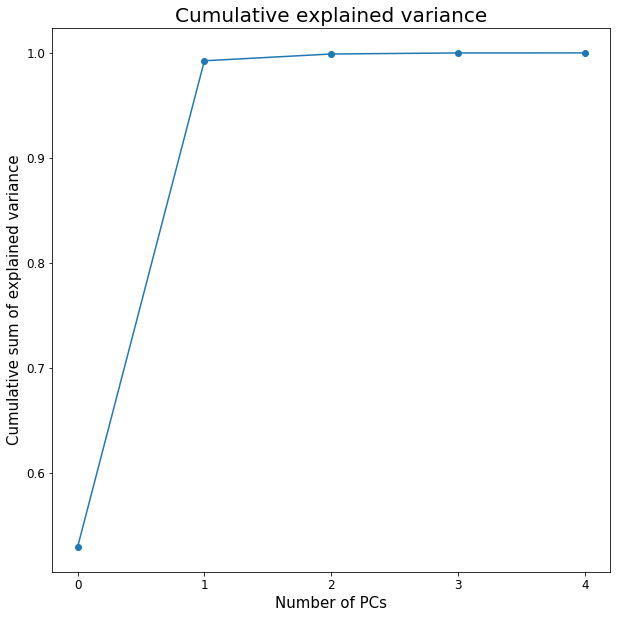

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(np.cumsum(PCA_dummy.explained_variance_ratio_), '-o')

plt.title("Cumulative explained variance", fontsize=20)

plt.xticks(np.arange(0, len(clean_numeric_cols)-1, 1), fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Number of PCs', fontsize=15)
plt.ylabel('Cumulative sum of explained variance' , fontsize=15)

plt.show()

The first two PC explain about 99% of the variance, hence dimensionality reduction in the numeric features (from **5** features to **2** components) is feasible.

In [ ]:
Xy_PCA = pd.DataFrame(Xy_PCA)

In [ ]:
Xy_PCA = pd.DataFrame(Xy_PCA).iloc[:,0:2]
Xy_PCA.columns = ["PC1","PC2"]

In [ ]:
dummified_Xy_PCA = pd.concat([dummified_Xy, Xy_PCA], axis=1)

In [ ]:
dummified_Xy_PCA.drop(clean_numeric_cols[1:], axis=1, inplace=True)

In [ ]:
basic_X_train_PCA = dummified_Xy_PCA[dummified_Xy_PCA["status_group"] != "test"].drop(["status_group"], axis = 1)
basic_y_train = dummified_Xy[dummified_Xy["status_group"] != "test"]["status_group"].astype("category")

In [ ]:
basic_model_pca, score = train_model(basic_X_train_PCA,
                                     basic_y_train,
                                     linear_model.LogisticRegression(max_iter = 10000, solver = 'lbfgs', penalty = 'none', multi_class = 'auto'),
                                     False)

Accuracy = 0.5431


In [ ]:
results_df.loc[len(results_df)] = ['LogReg Baseline FE PCA', score, basic_X_train_PCA.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93


The accuracy result drops notably, which corroborates the intuition that in the absence of significant correlations PCA does not provide great benefit.

### Filtering Methods for Feature Selection
With these type of selection methods, the features are ranked according to their predictive power according to the following methodologies: the Chi Squared Independence test and the Information Gain.

#### Chi-Squared Selection
This method measures the relationship between the features and the target feature by using the chi squared selection. Only those features are kept that are deemed 'representative enough'.

The following code computes the ChiSquared value for all the features. These values are then used to filter out the features with less importance according to the ChiSquared analysis. 

The removal of features depends on whether their significance lies below a predefined threshold, set here at the lowest quartile of the ChiSquared values.

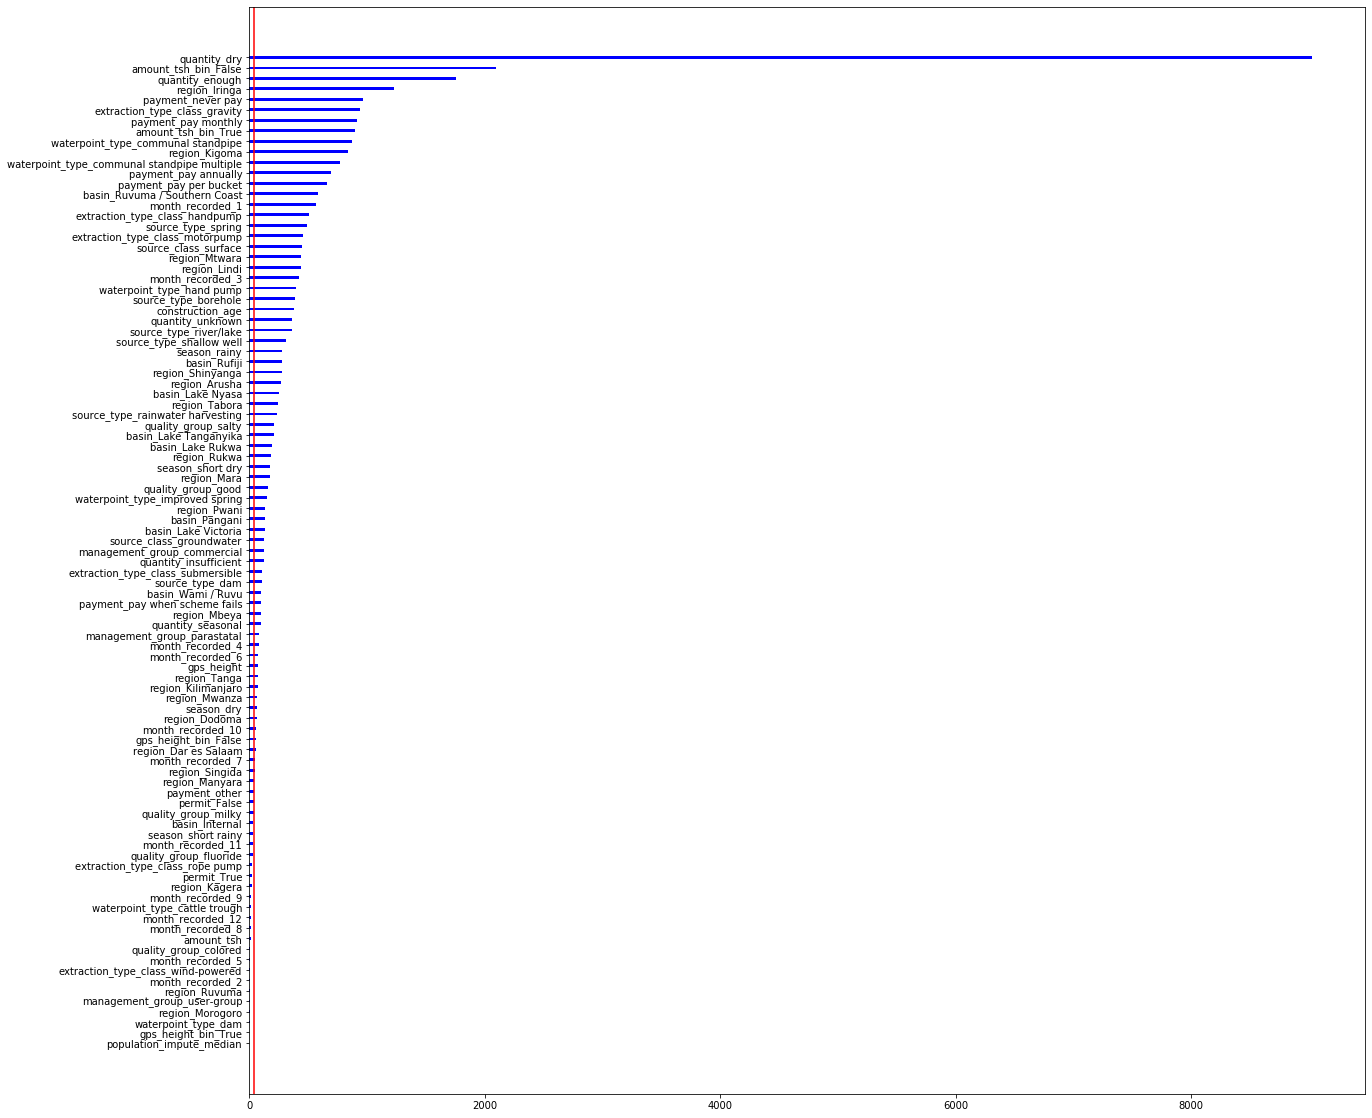

ChiSquared Threshold (lowest quartile) 40.74703936542787


In [ ]:
chi2_selector = SelectKBest(score_func=chi2).fit(basic_X_train,
                                                 basic_y_train)

indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = defaultdict(float)
for i in range(len(basic_X_train.columns)):
    chi2_features[basic_X_train.columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
items = sorted(chi2_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(20,20))
plt.yticks(list(range(0,3*len(keys),3)), keys, rotation=0, fontsize=10)
plt.barh(list(range(0,3*len(keys),3)), values, color='b', align='center')
chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25)
plt.axvline(chi2_th, color='red')
plt.gca().invert_yaxis()

plt.show()

print("ChiSquared Threshold (lowest quartile)", chi2_th)

The figure above shows that the threshold is basically removing features that are not significantly related to the target variable.

Now it is possible to remove any feature with a Chi Squared test statistic **below the specified threshold** and train the basic logistic regression model just on this subset of features:

In [ ]:
chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()

print("{0} features to remove:".format(len(chi2_features_to_remove)))
print('\n'.join(list(chi2_features_to_remove)))

chi2_X_train = dummified_Xy[dummified_Xy["status_group"] != "test"].drop(list(chi2_features_to_remove) + ["status_group"], axis = 1)

chi2_model, score = train_model(chi2_X_train,
                                basic_y_train,
                                linear_model.LogisticRegression(max_iter=10000, penalty='none', solver='lbfgs', multi_class = 'auto'),
                                False)

chi2_cols = chi2_X_train.columns

24 features to remove:
permit_False
quality_group_milky
basin_Internal
season_short rainy
month_recorded_11
quality_group_fluoride
extraction_type_class_rope pump
permit_True
region_Kagera
month_recorded_9
waterpoint_type_cattle trough
month_recorded_12
month_recorded_8
amount_tsh
quality_group_colored
month_recorded_5
extraction_type_class_wind-powered
month_recorded_2
region_Ruvuma
management_group_user-group
region_Morogoro
waterpoint_type_dam
gps_height_bin_True
population_impute_median
Accuracy = 0.7277


Chi Square feature selection shows as water level(quantity) dry/enough as mosts important features for determining the reason of functionally in water pumps. It is reasonable that when the level of water is low the water pump will tend to malfunction. This feature shows the same representation as the amount of water (total static head) available to the waterpoint labelled as *False*, i.e. no water available at the pump. However this could also mean that these are gravity class waterpoints what will be confirmed by the **extraction_type_gravity** feature. 

The feature **amount_tsh** is more relevant as binary. **population** is not significant despite the imputation.

In [ ]:
results_df.loc[len(results_df)] = ['LogReg ChiSquared Selection', score, chi2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72


#### Information Gain Selection

The Information Gain (IG) selection is applied and compared below, keeping the same significance threshold at the lowest quartile:

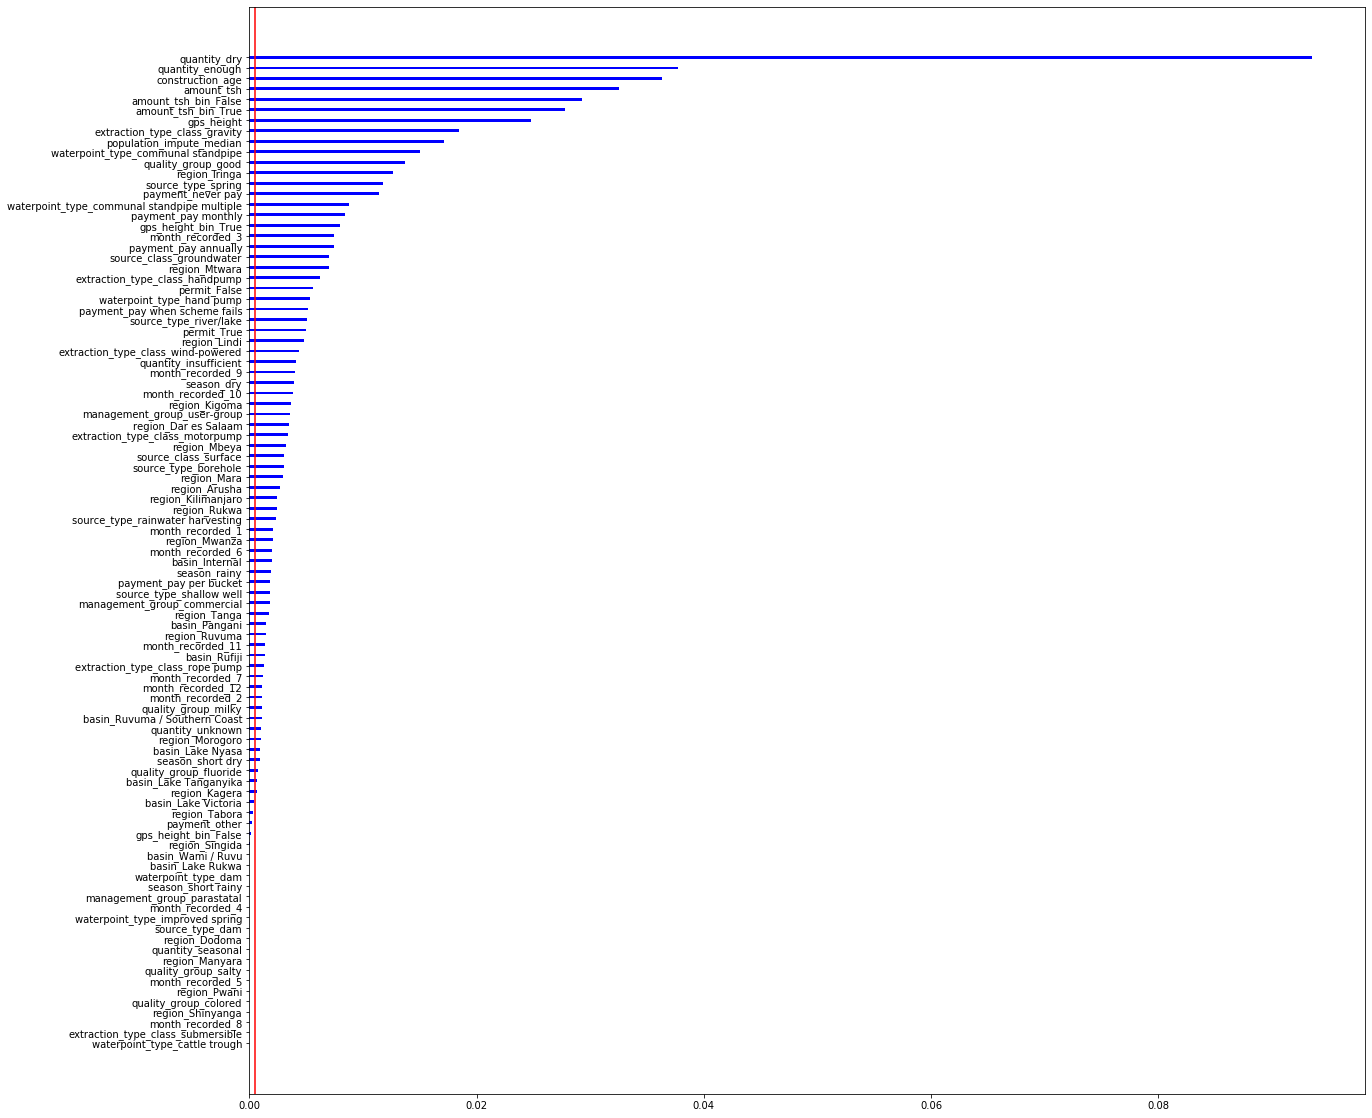

Information Gain Threshold (lowest quartile) 0.0005362651608171731


In [ ]:
ig_selector = SelectKBest(score_func=mutual_info_classif).fit(basic_X_train,
                                                              basic_y_train)

indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = defaultdict(float)
for i in range(len(basic_X_train.columns)):
    ig_features[basic_X_train.columns[indices[i]]] += ig_selector.scores_[indices[i]]
    
items = sorted(ig_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(20,20))
plt.yticks(list(range(0,3*len(keys),3)), keys, rotation=0, fontsize=10)
plt.barh(list(range(0,3*len(keys),3)), values, color='b', align='center')
ig_th = pd.Series(list(ig_features.values())).quantile(0.25)
plt.axvline(ig_th, color='red')
plt.gca().invert_yaxis()

plt.show()

print("Information Gain Threshold (lowest quartile)", ig_th)

The Information Gain threshold is effectively 0. Proceed to filter out features below the threshold:

In [ ]:
ig_features_to_remove = dict(filter(lambda x: x[1] <= ig_th, ig_features.items())).keys()

print("{0} features to remove:".format(len(ig_features_to_remove)))
print('\n'.join(list(ig_features_to_remove)))

ig_X_train = dummified_Xy[dummified_Xy["status_group"] != "test"].drop(list(ig_features_to_remove) + ["status_group"], axis = 1)

ig_model, score = train_model(ig_X_train,
                              basic_y_train,
                              linear_model.LogisticRegression(max_iter=10000, penalty='none', solver='lbfgs', multi_class = 'auto'),
                              False)

ig_cols = ig_X_train.columns

24 features to remove:
basin_Lake Victoria
region_Tabora
payment_other
gps_height_bin_False
region_Singida
basin_Wami / Ruvu
basin_Lake Rukwa
waterpoint_type_dam
season_short rainy
management_group_parastatal
month_recorded_4
waterpoint_type_improved spring
source_type_dam
region_Dodoma
quantity_seasonal
region_Manyara
quality_group_salty
month_recorded_5
region_Pwani
quality_group_colored
region_Shinyanga
month_recorded_8
extraction_type_class_submersible
waterpoint_type_cattle trough
Accuracy = 0.7220


In [ ]:
results_df.loc[len(results_df)] = ['LogReg IG Selection', score, ig_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72


Information gain shows similar features than Chi selection, at least the most relevant ones. Amongst them, IG considers age of the pump as an influencing factor, meaning old pumps could have more problems. Try removing the binarised feature **amount_tsh_bin**:

In [ ]:
basic_X_train1 = basic_X_train.drop(["amount_tsh_bin_True","amount_tsh_bin_False"], axis = 1)

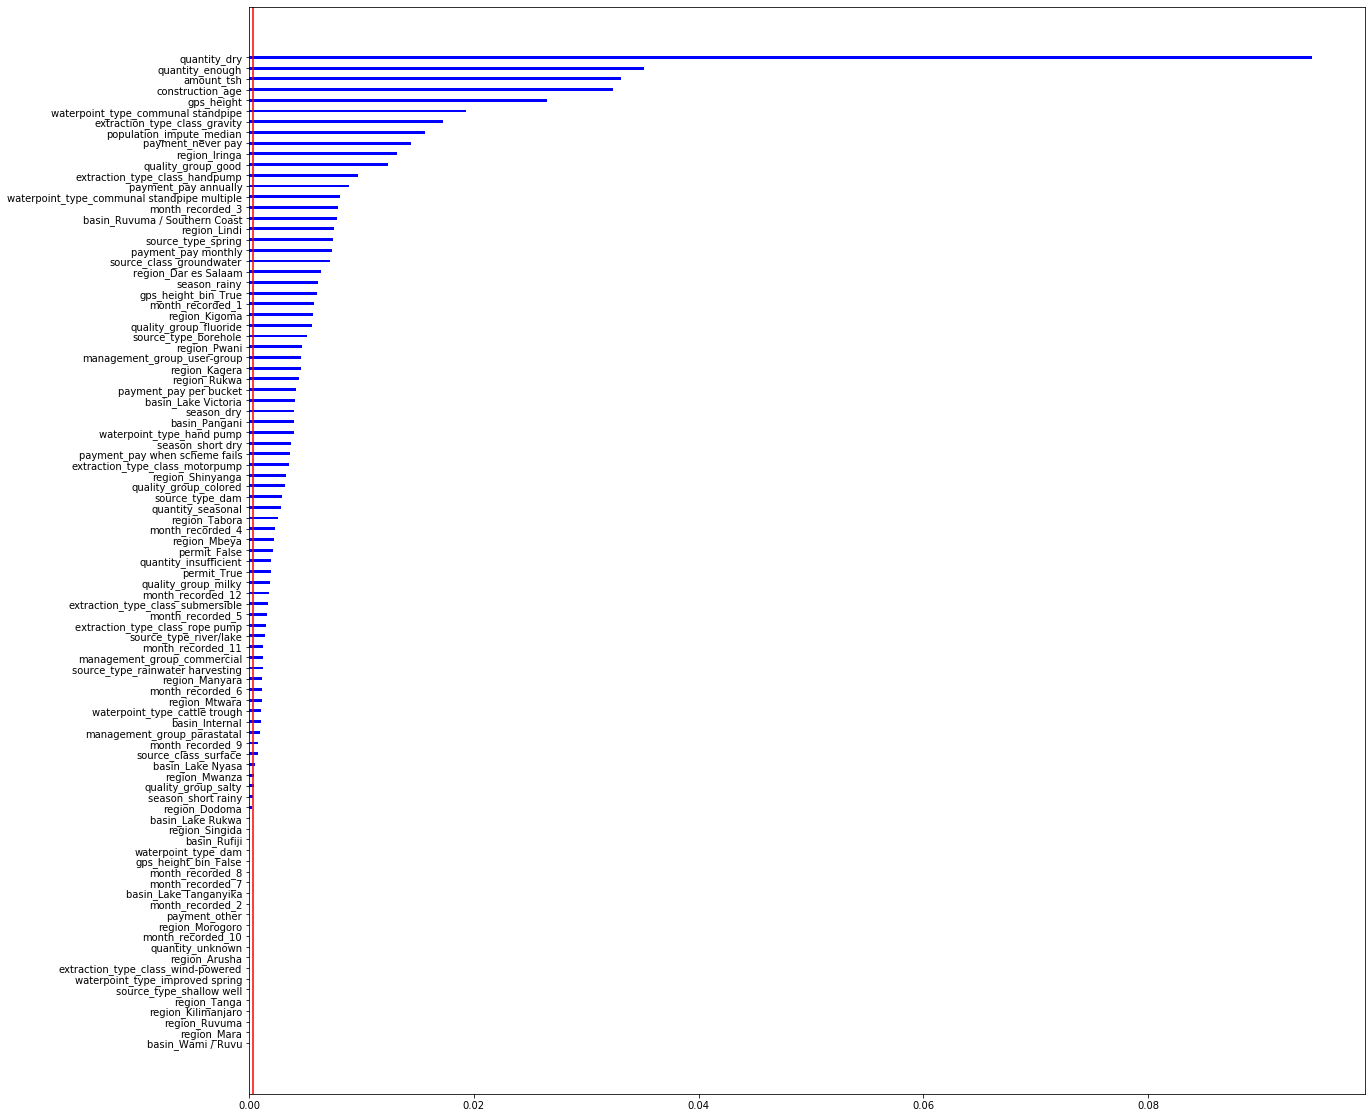

Information Gain Threshold (lowest quartile) 0.0003114148518414961


In [ ]:
ig_selector = SelectKBest(score_func=mutual_info_classif).fit(basic_X_train1,
                                                              basic_y_train)

indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = defaultdict(float)
for i in range(len(basic_X_train1.columns)):
    ig_features[basic_X_train1.columns[indices[i]]] += ig_selector.scores_[indices[i]]
    
items = sorted(ig_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(20,20))
plt.yticks(list(range(0,3*len(keys),3)), keys, rotation=0, fontsize=10)
plt.barh(list(range(0,3*len(keys),3)), values, color='b', align='center')
ig_th = pd.Series(list(ig_features.values())).quantile(0.25)
plt.axvline(ig_th, color='red')
plt.gca().invert_yaxis()

plt.show()

print("Information Gain Threshold (lowest quartile)", ig_th)

In [ ]:
ig_features_to_remove = dict(filter(lambda x: x[1] <= ig_th, ig_features.items())).keys()

print("{0} features to remove:".format(len(ig_features_to_remove)))
print('\n'.join(list(ig_features_to_remove)))

ig2_X_train = dummified_Xy[dummified_Xy["status_group"] != "test"].drop(list(ig_features_to_remove) + \
                                                                       ["amount_tsh_bin_True","amount_tsh_bin_False","status_group","population_impute_median"], axis = 1)

ig2_model, score = train_model(ig2_X_train,
                               basic_y_train,
                               linear_model.LogisticRegression(max_iter=10000, penalty='none', solver='lbfgs', multi_class = 'auto'),
                               False)

ig2_cols = ig2_X_train.columns

24 features to remove:
season_short rainy
region_Dodoma
basin_Lake Rukwa
region_Singida
basin_Rufiji
waterpoint_type_dam
gps_height_bin_False
month_recorded_8
month_recorded_7
basin_Lake Tanganyika
month_recorded_2
payment_other
region_Morogoro
month_recorded_10
quantity_unknown
region_Arusha
extraction_type_class_wind-powered
waterpoint_type_improved spring
source_type_shallow well
region_Tanga
region_Kilimanjaro
region_Ruvuma
region_Mara
basin_Wami / Ruvu
Accuracy = 0.7273


In [ ]:
results_df.loc[len(results_df)] = ['LogReg IG Selection_2', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69


### Embedded Methods

In this section, embedded methods are applied to create the models for evaluation.

#### Ridge

A Ridge classifier is trained on the subset of features given by Information Gain (2). As there is a trade-off between variance and bias, cross-validation is used to find the optimal regularisation parameter value `C^-1`.

In [ ]:
warnings.filterwarnings("ignore", category = FutureWarning)

In [ ]:
alphas = 10**np.linspace(1, -3, 100)

ridge_model_cv = linear_model.RidgeClassifierCV(alphas=alphas, cv=10)

In [ ]:
ridge_model_cv , score = train_model(ig2_X_train,
                                     basic_y_train,
                                     ridge_model_cv,
                                     False)

Accuracy = 0.7265


Check the hyperparameter `alpha` selection through CV

In [ ]:
ridge_model_cv.alpha_

0.6135907273413173

In [ ]:
results_df.loc[len(results_df)] = ['LogReg CV Ridge', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69


#### Lasso

Now cross-validation is included with a Lasso classifier based on the features given by Information Gain (2). Consider to this end a potential range for `C` between approx. 1.26 and 0.001:

In [ ]:
alphas = 10**np.linspace(0.1,-3,10)

In [ ]:
lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=100, penalty='l1', solver='liblinear', Cs=list(alphas), cv=5,  multi_class='auto')

Accuracy = 0.7262


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


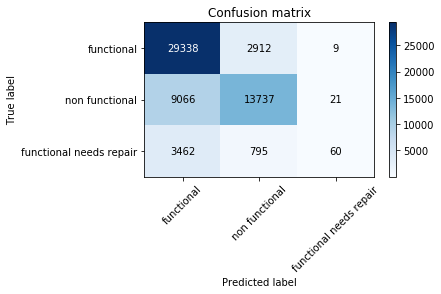

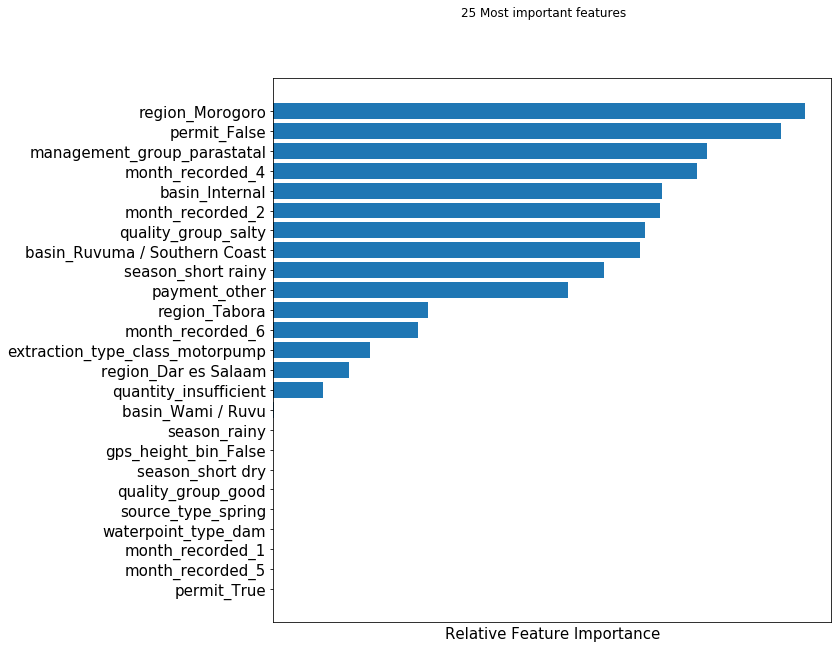

In [ ]:
lasso_model_cv, score = train_model(ig2_X_train,
                                    basic_y_train,
                                    lasso_mod_cv)

Check the hyperparameter selection through cross-validation:

In [ ]:
lasso_model_cv.C_

array([0.25769804, 0.05274997, 1.25892541])

In [ ]:
results_df.loc[len(results_df)] = ['LogReg CV Lasso', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69
8,LogReg CV Lasso,0.726178,69


Lasso feature selection is based in region (Rukwa, Ruvuma) and basin (Wami, Rufiji). Telling us that region and basin from where water pumps came from have a relation with functionality. 

### K-Nearest Neighbors Classifier

A basic gird search for the optimal hyperparameter **n_neighbors** is performed, with a 5-fold cross validation:

In [ ]:
knn = KNeighborsClassifier(metric = 'minkowski', p = 2)

param_grid = {'n_neighbors': np.arange(1, 5, 2)}

In [ ]:
knn_cv = GridSearchCV(knn, param_grid, cv=5)

In [ ]:
knn_cv.fit(ig2_X_train,basic_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([1, 3])}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [ ]:
knn_cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn_pred = cross_val_predict(knn_cv, ig2_X_train, basic_y_train, cv=5)

In [ ]:
score = accuracy_score(basic_y_train,knn_pred)
score

0.762003367003367

In [ ]:
results_df.loc[len(results_df)] = ['KNN CV', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69
8,LogReg CV Lasso,0.726178,69
9,KNN CV,0.762003,69


### Ensemble Classifier: Random Forest

Initially, try a Random Forest classifier with all defaults on the subset of features given by Information Gain (2).

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf_model, score = train_model(ig2_X_train,
                              basic_y_train,
                              rf,
                              False)

Accuracy = 0.7809


In [ ]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = ig2_X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)

,importance
gps_height,0.187428
construction_age,0.103685
population_impute_mean,0.098634
quantity_dry,0.086742
amount_tsh,0.040951
quantity_enough,0.037350
waterpoint_type_communal standpipe,0.024013
extraction_type_class_handpump,0.023936
quantity_insufficient,0.021506
payment_never pay,0.019604


The wells altitude represented as `gps_height`, `age` of water pumps, `population` surrounding them combined with `quantity` of water in the pump qualified as `dry` makes the most important features for predicting water pump functionality. 
The Government of Tanzania should evaluate old pumps that could have a lower performance and include a sensor in all the pumps with low quantity of water(dry/enough) to prevent forcing the machine to the point of breaking it. Also, they should take a closer look to handpumps and determine if an update for these mechanisms could be made specially in high population locations. Tanzania water has lots of influence of seasons, and its government has to learn how to manage these seasons in a productive way.  


In [ ]:
results_df.loc[len(results_df)] = ['RF CV defaults', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69
8,LogReg CV Lasso,0.726178,69
9,KNN CV,0.762003,69


### Random Forest - visualize one tree
A tree is pulled from the forest, limiting the `max_depth` of the tree to 3, so the decision path can be visualized.

In [ ]:
# pull one tree from the forrest 
tree = rf_model.estimators_[5]

# assign feature and class names for visualization
feature_names = list(ig2_X_train.columns.values)
class_names = rf_model.classes_

export_graphviz(tree, out_file = 'tree.dot', 
                feature_names = feature_names, 
                class_names = class_names, 
                rounded = True, precision = 1, 
                max_depth = 3, 
                filled = True)

# create the graph from dot file
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# write graph to png file
graph.write_png('tree.png')

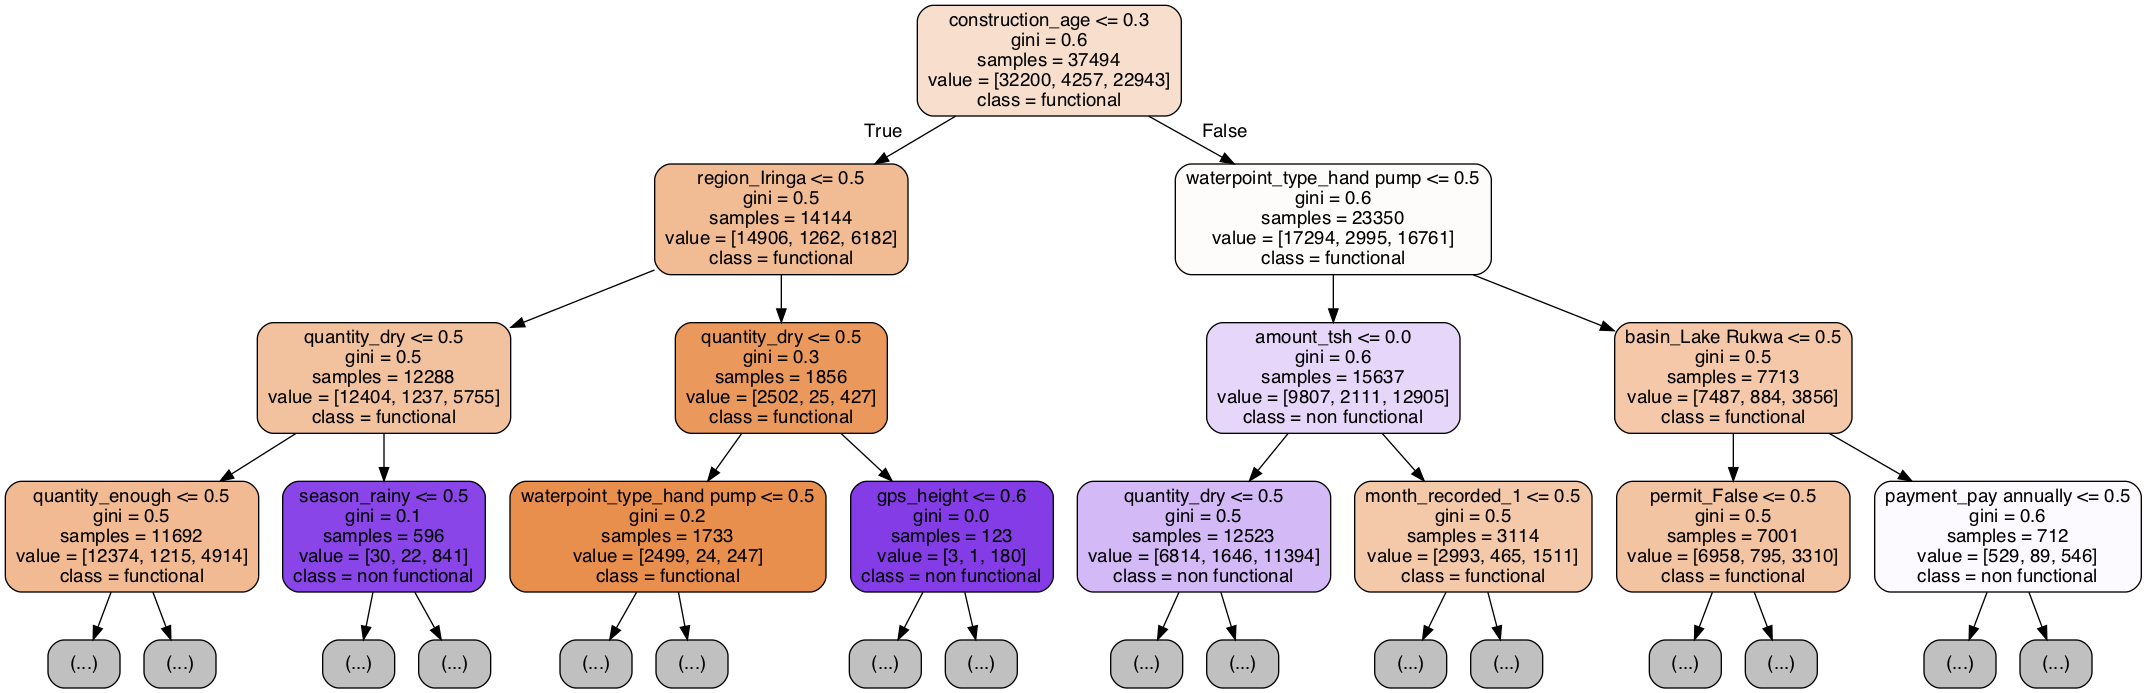

In [ ]:
Image(filename = 'tree.png')

In light of the good accuracy result, define a randomised search for some hyperparameters (**n_estimators** and **max_depth**):

#### Random Forest with Randomized Grid Search

In [ ]:
rf_param_grid = {'n_estimators':randint(100, 150),
                 'max_depth': randint(3, 8)}

In [ ]:
rf_cv = RandomizedSearchCV(RandomForestClassifier(), 
                           rf_param_grid,
                           scoring='accuracy',
                           cv=5)

In [ ]:
rf_cv.fit(ig2_X_train, basic_y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_cv.best_params_

{'max_depth': 6, 'n_estimators': 149}

In [ ]:
rf_cv_pred = cross_val_predict(rf_cv, ig2_X_train, basic_y_train, cv=5)

In [ ]:
score = accuracy_score(basic_y_train, rf_cv_pred)
score

0.7364814814814815

The randomised search does not necessarily yield better accuracy results. The defined parameter grid is rather basic, but this is intended as otherwise the computational load becomes significant. This is also the reason why a thorough grid search is discarded. Consequently, the resulting set of hyperparameters does not have to be optimal, or even more suitable than the default ones in this case.

In [ ]:
results_df.loc[len(results_df)] = ['RF CV randSearch', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69
8,LogReg CV Lasso,0.726178,69
9,KNN CV,0.762003,69


### Ensemble Classifier: XGBoost

Initially, try a boosting classifier with all defaults

In [ ]:
xgb = xgboost.XGBClassifier(objective = "binary:logistic")

In [ ]:
xgb_model, score = train_model(ig2_X_train,
                               basic_y_train,
                               xgb,
                               False)

Accuracy = 0.7362


In [ ]:
results_df.loc[len(results_df)] = ['XgBoost CV', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69
8,LogReg CV Lasso,0.726178,69
9,KNN CV,0.762003,69


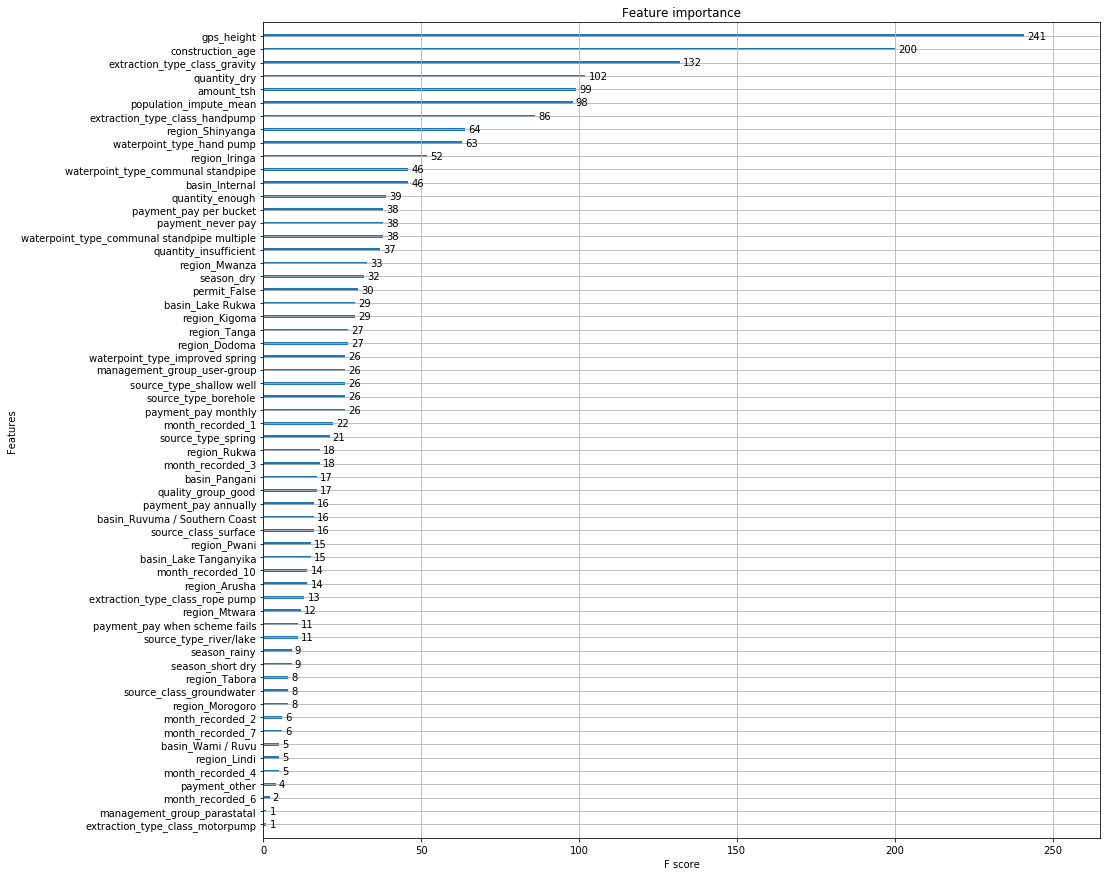

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
xgboost.plot_importance(xgb_model, ax=ax)
plt.show()

## SVC Multiclass Classification

A Support Vector Classification algorithm for multiclass classification is explored here, with default kernel `rbf` and decision function shape set to `ovo` or `one against one`. The regularization is set to `C=1.0`

In [ ]:
# Support Vector Classifier with default parameters, Regularization (C=1.0), Kernel='rbf'
# probability=False. Decision function shape = 'ovo' "one against one" used for multiclass

clf = svm.SVC(decision_function_shape='ovo')

In [ ]:
clf, score = train_model(ig2_X_train,
                         basic_y_train,
                         clf,
                         False)

Accuracy = 0.7651


In [ ]:
results_df.loc[len(results_df)] = ['SVC Multiclass CV', score, ig2_X_train.shape[1]]
results_df

,Approach,Accuracy,Number of features
0,Raw LogReg baseline,0.724228,98
1,LogReg Baseline FE median,0.730774,95
2,LogReg Baseline FE mean,0.730758,95
3,LogReg Baseline FE PCA,0.543081,93
4,LogReg ChiSquared Selection,0.727694,72
5,LogReg IG Selection,0.721953,72
6,LogReg IG Selection_2,0.726599,69
7,LogReg CV Ridge,0.726549,69
8,LogReg CV Lasso,0.726178,69
9,KNN CV,0.762003,69


# Final Submission

Upon inspection of the final **results** table, it is noteworthy that many of the evaluated models have accuracy metrics within a narrow range. Hence, the final model choice needs to accommodate an equilibrium between simplicity, computational load, economy and clarity of features, and realibility when processing new unseen data.

In this sense, the **Random Forest** is favoured over all other candidates. It is intuitive and a suitable alternative for cases with a large number of features, as it comprises a set of trees learning in parallel. As shown in the section above, it attains a high accuracy score even when fitting the model with all defaults over the subset of features resulting from Information Gain.

The piece of code below retrieves the selected final model (RF), generates the predictions for the test set and creates the submission file with the required format (a column with `id` and a column with the predictions `status_group`):

In [ ]:
final_model = rf_model

X_test = dummified_Xy[dummified_Xy["status_group"] == "test"][ig2_cols]

# Test prediction
final_pred = final_model.predict(X_test)
predictions = pd.DataFrame({"id": dummified_Xy[dummified_Xy["status_group"] == "test"].index,
                            "status_group": final_pred})

predictions.to_csv(my_path + "predictions.csv", index=False)